### 코로나 재난지원금의 목적

#### 재난지원금 지원은 코로나바이러스감염증-19(코로나19)로 인한 국민들의 경제적 어려움을 돕겠다는 것이 기본 취지지만,
#### 더 나아가 소비 지출을 늘려 국가 경제와 지역 경제를 살리겠다는 경기 부양의 목적도 갖는다

#### 프로젝트 주제
2020년 5월~8월 제주지역 시간별, 업종별, 지역별 소비금액 및 재난지원금의 소비형태를 다양한 시각으로 분석 및 시각화

재난지원금의 목적에 따라 제주지역의 재난지원금 사용 행태를 지역별/업종별 소비 행태를 파악하고
이를 통해 지역적 특성을 파악한다.

#### 프로젝트 진행 순서
간단한 데이터 전처리 후 기간별(월/시간), 업종별, 업종규모별, 지역별 등으로 세분화하여 데이터 시각화를 진행

1.	데이터 전처리
>- 읍면동 좌표 추가 및 좌표 변환 
>- 자료 병합 및 칼럼 삭제
    
2.	데이터 분석
>- 총이용금액과 재난지원금 사용 기간(월/시간)별 분석
>- 총이용금액과 재난지원금 사용 업종별 분석
>- 총이용금액과 재난지원금 사용 업종규모별 분석
>- 총이용금액과 재난지원금 사용 지역별 분석
    
3.	시각화
>- 다양한 그래프 사용(막대, 꺾은선, 원그래프 등)

#### 필요 모듈 불러오기 / 시각화를 위한 한글 폰트 설정(windows)

In [14]:
from pyproj import Proj, transform, Transformer #좌표 변환시 사용 -> !pip install pyproj -> 설치 필요
import pandas as pd
import numpy as np
import json
import requests #http 사용을 위한 라이브러리
import pickle #대용량 데이터 저장

import warnings #붉은 경고창 안뜨게 하기
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt #그래프 시각화
import seaborn as sns #matplotlib 기반의 시각화 라이브러리

import folium #지리 정보 시각화

from tqdm import tqdm #진행상황 확인 -> 여기서는 안썼는데 유용해서 기억해두기

from shapely.geometry import shape, Point #다각형, 선, 점의 벡터 파일을 다룰 때 사용

from collections import Counter #빈도수 카운트

# 웹크롤링시 사용
# from selenium import webdriver
# from bs4 import BeautifulSoup
# import time
# import re
# from selenium.webdriver.common.by import By #기존 셀레니움 사용시 오류 발생 -> 꼭 import By 필요
# import datetime #특정 날짜부터 크롤링하기 위하여 사용
# from dateutil.relativedelta import relativedelta

In [2]:
#Windows 한글 폰트 설정
import matplotlib.pyplot as plt
 
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#### 제주도 읍면동 좌표가 있는 json 파일을 불러오기

In [176]:
# 문서 내 좌표는 제주시, 서귀포시로만 구분되어 있어서 읍면동 자료를 추가

# http://data.nsdi.go.kr/dataset/15145 국가공간정보포털에서 제주 읍면동 shp 파일을 다운로드
# shp 파일을 Geojson 파일로 변환

# mapshaper.org 
# shp 파일 끌어오기
# snap vertices 체크
# encoding=utf-8 입력 후 import
# simplify 적용 => 제주는 지역이 작아서 따로 적용치 않음
# 콘솔에 '-proj from=EPSG:5178 crs=EPSG:4326' 입력 
#     -> 불러온 파일의 좌표계가 epsg:5178이어서 사용하기 편한 epsg:4326로 변환

In [3]:
# import json
# 제주도 읍면동 좌표가 있는 json 파일을 불러오기
# jeju=json.load(open("jeju_json.json", encoding='euc-kr'))

#위 방식으로 하면 키 부분이 제대로 안나옴

In [3]:
# import json
# 제주도 읍면동 좌표가 있는 json 파일을 불러오기
jeju_sgg_geo=json.load(open("jeju_sgg.geojson", encoding='utf-8'))

In [4]:
jeju_sgg_geo

{'type': 'FeatureCollection',
 'name': 'temp',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'OBJECTID': 3394,
    'adm_nm': '제주특별자치도 제주시 한림읍',
    'adm_cd': '3901011',
    'adm_cd2': '5011025000',
    'sgg': '50110',
    'sido': '50',
    'sidonm': '제주특별자치도',
    'sggnm': '제주시'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[126.23127933634665, 33.4047465707345],
       [126.22993897332888, 33.40412962446276],
       [126.22589028533956, 33.40408960161301],
       [126.22500509205072, 33.404219774806876],
       [126.22487574987228, 33.40424582326579],
       [126.2233554133589, 33.40497269590151],
       [126.22323427626428, 33.40503080086705],
       [126.22243703533582, 33.40548011869599],
       [126.22209085104105, 33.405681356174604],
       [126.22201762958439, 33.405787125027516],
       [126.22198203505886, 33.40588897944633],
       [126.22180012754559, 33.410023490935

#### 텍스트 문서로 되어 있는 5~8월 제주도 소비 자료 불러오기

In [5]:
# import pandas as pd
# 텍스트 문서로 되어 있는 5~8월 제주도 소비 자료 불러오기

def loading_txt(month_5678):
    return pd.read_table("KRI-DAC_Jeju_data" + month_5678 + ".txt",sep=",")

jeju5_df = loading_txt("5") #273183
jeju6_df = loading_txt("6") #281896
jeju7_df = loading_txt("7") #284265
jeju8_df = loading_txt("8") #280085


# for i in range(5,9):
#     df_=loading_txt{i}
#     f'jeju{i}_df'=df_

#### 5~8월 데이터 병합 후 이전 좌표와 사용하지 않는 'OBJECTID','Field1','SIDO' 삭제 및 컬럼 이름 변경

In [5]:
#5~8월 데이터 병합 후 이전 좌표와 사용하지 않는 'OBJECTID','Field1','SIDO' 삭제
total = pd.concat([jeju5_df,jeju6_df,jeju7_df,jeju8_df])
total = total.drop(['OBJECTID','Field1','SIDO'],axis=1)
total = total.reset_index(drop=True)
total.columns = total.columns.str.lower() #앞자리 대문자인 게 번거로워서 소문자로 바꿈
#영어로 하려니 헷갈려서 한국어로 바꿈
total.rename(columns={'ym':'월','sigungu':'시군구','franclass':'소상공인','type':'업종','time':'시간','totalspent':'총사용금액','disspent':'재난지원금','numofspent':'총이용건수','numofdisspent':'총재난지원금이용'}, inplace=True)

#### 좌표계를 EPSG:5178 -> EPSG:4326로 변환

In [6]:
# from pyproj import Proj, transform, Transformer
# 데이콘에서 제공된 데이터의 좌표계가 EPSG:5178이어서 EPSG:4326로 변환

proj_UTMK = Proj(init='epsg:5178')
proj_WGS84 = Proj(init='epsg:4326')

total['x'],total['y'] = transform(proj_UTMK, proj_WGS84, total['point_x'].tolist(), total['point_y'].tolist())

In [7]:
total = total.drop(['point_x','point_y'],axis=1)
total.head() #1119429

,월,시군구,소상공인,업종,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y
0,202005,제주시,영세,일반한식,00시,363000,66500,10,2,126.176746,33.305090
1,202005,제주시,영세,단란주점,00시,1180000,0,3,0,126.176737,33.305540
2,202005,제주시,중소1,편의점,00시,157670,6850,20,2,126.177311,33.303746
3,202005,제주시,영세,편의점,00시,46600,0,2,0,126.177283,33.305098
4,202005,제주시,영세,주점,00시,66000,0,2,0,126.177264,33.305999


#### 시간대 정리(25개 분류 -> 6개)

In [8]:
#출력시 x시 -> 승인 없이 결제된 시간대
#시간이 너무 세분화 되어 있어 6개 영역으로 제한(4개로 분배하니 오후와 저녁이 차이가 너무 없음)
def 시간_분배(t):
    if '00'<= t <'04':
        return '새벽'
    elif '04'<= t <'08':
        return '아침'
    elif '08'<= t <'12':
        return '오전'
    elif '12'<= t <'16':
        return '점심'
    elif '16'<= t <'20':
        return '오후'
    else:
        return '저녁'
    
total['시간_분배'] = total['시간'].apply(시간_분배)

#x시는 승인 없이 결제된 시간이므로 '승인안됨'으로 처리
total.loc[total['시간']=='x시','시간_분배'] ='승인안됨'

In [128]:
total

,월,시군구,소상공인,업종,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y,시간_분배
0,202005,제주시,영세,일반한식,00시,363000,66500,10,2,126.176746,33.305090,새벽
1,202005,제주시,영세,단란주점,00시,1180000,0,3,0,126.176737,33.305540,새벽
2,202005,제주시,중소1,편의점,00시,157670,6850,20,2,126.177311,33.303746,새벽
3,202005,제주시,영세,편의점,00시,46600,0,2,0,126.177283,33.305098,새벽
4,202005,제주시,영세,주점,00시,66000,0,2,0,126.177264,33.305999,새벽
...,...,...,...,...,...,...,...,...,...,...,...,...
1119424,202008,제주시,영세,편의점,x시,13700,0,2,0,126.962369,33.515632,승인안됨
1119425,202008,제주시,영세,일반한식,x시,56000,0,1,0,126.962928,33.513833,승인안됨
1119426,202008,제주시,영세,일반한식,x시,28000,0,1,0,126.964580,33.510691,승인안됨
1119427,202008,제주시,중소1,중국음식,x시,46000,0,3,0,126.965779,33.500332,승인안됨


#### 총 '1119429' 용량이 커서 피클로 저장

In [9]:
#엑셀로 저장하려고 했으나 용량이 너무 커서 불가능
# total.to_excel('total.xlsx',index=False) #1119429

#피클로 저장
#import pickle

with open('total.pickle', 'wb') as f:
    pickle.dump(total, f)

#피클 불러오기
with open("total.pickle","rb") as f:
    total = pickle.load(f)

####  카카오 api를 이용하여 테이블 내 좌표로 주소 불러오기

In [11]:
#좌표 구분 칼럼 생성
#좌표를 문자열로 변환 후 이어주기
total['x'] = total['x'].astype(str)
total['y'] = total['y'].astype(str)
total['lon_lat'] = total['x']+'_'+total['y']

In [13]:
#중복 좌표 삭제
totalxy = total.drop_duplicates('lon_lat')
totalxy.value_counts('lon_lat')

lon_lat
126.16155729096499_33.33822275800645     1
126.56045285400002_33.24790754865389     1
126.55690905422803_33.26770194136964     1
126.55691032553507_33.49580443984206     1
126.55691645146733_33.26725122353073     1
                                        ..
126.48227236091873_33.48725124072313     1
126.48228020664646_33.486800554417876    1
126.48228805223022_33.486349868078065    1
126.48229589767007_33.48589918170371     1
126.96738273909291_33.50124732887421     1
Length: 15369, dtype: int64

In [14]:
#url 생성
totalxy['url1'] = 'https://dapi.kakao.com/v2/local/geo/coord2regioncode.json?x=' + totalxy['x']
totalxy['url2'] = '&y=' + totalxy['y']
totalxy['url'] = totalxy['url1'] + totalxy['url2']

totalxy.drop(columns=['url1','url2'],axis=1,inplace=True)
totalxy = totalxy.reset_index()
totalxy.head()

,index,월,시군구,소상공인,업종,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y,시간_분배,lon_lat,url
0,0,202005,제주시,영세,일반한식,00시,363000,66500,10,2,126.17674597473471,33.30508967004505,새벽,126.17674597473471_33.30508967004505,https://dapi.kakao.com/v2/local/geo/coord2regi...
1,1,202005,제주시,영세,단란주점,00시,1180000,0,3,0,126.17673661244419,33.305540299877514,새벽,126.17673661244419_33.305540299877514,https://dapi.kakao.com/v2/local/geo/coord2regi...
2,2,202005,제주시,중소1,편의점,00시,157670,6850,20,2,126.17731071479304,33.30374564295667,새벽,126.17731071479304_33.30374564295667,https://dapi.kakao.com/v2/local/geo/coord2regi...
3,3,202005,제주시,영세,편의점,00시,46600,0,2,0,126.17728263513888,33.305097531163554,새벽,126.17728263513888_33.305097531163554,https://dapi.kakao.com/v2/local/geo/coord2regi...
4,4,202005,제주시,영세,주점,00시,66000,0,2,0,126.17726391376034,33.305998790085305,새벽,126.17726391376034_33.305998790085305,https://dapi.kakao.com/v2/local/geo/coord2regi...


In [59]:
# import requests
# import json

donglist = []

for i in range(len(totalxy.index)):
    url = totalxy['url'][i]
    headers = {"Authorization": "KakaoAK " + 'rest api'}
    result = json.loads(str(requests.get(url, headers=headers).text))
    match_first = result['documents'][0]['address_name']
    donglist.append(match_first)

In [25]:
# 가져온 주소값 데이터프레임 변환 
dic = {'dong':donglist}
df_dong = pd.DataFrame(dic)
df_dong.tail()

# 기존 데이터프레임과 더하기
df_join = totalxy.join(df_dong)
df_join.head()

,index,월,시군구,소상공인,업종,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y,시간_분배,lon_lat,url,dong
0,0,202005,제주시,영세,일반한식,00시,363000,66500,10,2,126.17674597473471,33.30508967004505,새벽,126.17674597473471_33.30508967004505,https://dapi.kakao.com/v2/local/geo/coord2regi...,제주특별자치도 제주시 한경면 고산리
1,1,202005,제주시,영세,단란주점,00시,1180000,0,3,0,126.17673661244419,33.305540299877514,새벽,126.17673661244419_33.305540299877514,https://dapi.kakao.com/v2/local/geo/coord2regi...,제주특별자치도 제주시 한경면 고산리
2,2,202005,제주시,중소1,편의점,00시,157670,6850,20,2,126.17731071479304,33.30374564295667,새벽,126.17731071479304_33.30374564295667,https://dapi.kakao.com/v2/local/geo/coord2regi...,제주특별자치도 제주시 한경면 고산리
3,3,202005,제주시,영세,편의점,00시,46600,0,2,0,126.17728263513888,33.305097531163554,새벽,126.17728263513888_33.305097531163554,https://dapi.kakao.com/v2/local/geo/coord2regi...,제주특별자치도 제주시 한경면 고산리
4,4,202005,제주시,영세,주점,00시,66000,0,2,0,126.17726391376034,33.305998790085305,새벽,126.17726391376034_33.305998790085305,https://dapi.kakao.com/v2/local/geo/coord2regi...,제주특별자치도 제주시 한경면 고산리


In [114]:
#필요없는 컬럼 삭제
total_dong = df_join.drop(['lon_lat','url'],axis=1)
total_dong = total_dong.reset_index(drop=True)

In [115]:
#컬럼 이름 변경
total_dong=total_dong.rename(columns={'dong':'읍면동'})
total_dong.tail()

,index,월,시군구,소상공인,업종,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y,시간_분배,읍면동
15364,1108336,202008,서귀포시,영세,기타숙박업,23시,400000,0,1,0,126.83669450661048,33.37476694608944,저녁,제주특별자치도 서귀포시 성산읍 삼달리
15365,1109370,202008,제주시,영세,기타교육,x시,240000,0,1,0,126.29157226546015,33.44555685744748,승인안됨,제주특별자치도 제주시 한림읍 귀덕리
15366,1110636,202008,제주시,영세,기타교육,x시,300000,0,1,0,126.44463033542937,33.486334650861714,승인안됨,제주특별자치도 제주시 내도동
15367,1114504,202008,제주시,영세,농축수산품,x시,300000,0,1,0,126.52710600756265,33.47652147001685,승인안됨,제주특별자치도 제주시 오등동
15368,1115007,202008,제주시,영세,학원(회원제형태),x시,220000,0,1,0,126.53320341147531,33.49778058364405,승인안됨,제주특별자치도 제주시 이도이동


#### '읍면리' -> '읍면동' 으로 변환

In [116]:
#읍면동으로 나와야 하는데 '리'가 나와서 폴리움이 안됨
#읍면동 안에 '리'로 끝나는 행 추출
total_dong[total_dong['읍면동'].str.endswith('리')].head()

,index,월,시군구,소상공인,업종,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y,시간_분배,읍면동
0,0,202005,제주시,영세,일반한식,00시,363000,66500,10,2,126.17674597473471,33.30508967004505,새벽,제주특별자치도 제주시 한경면 고산리
1,1,202005,제주시,영세,단란주점,00시,1180000,0,3,0,126.17673661244419,33.305540299877514,새벽,제주특별자치도 제주시 한경면 고산리
2,2,202005,제주시,중소1,편의점,00시,157670,6850,20,2,126.17731071479304,33.30374564295667,새벽,제주특별자치도 제주시 한경면 고산리
3,3,202005,제주시,영세,편의점,00시,46600,0,2,0,126.17728263513888,33.305097531163554,새벽,제주특별자치도 제주시 한경면 고산리
4,4,202005,제주시,영세,주점,00시,66000,0,2,0,126.17726391376034,33.305998790085305,새벽,제주특별자치도 제주시 한경면 고산리


In [117]:
#읍면동 중복 제거 후 다시 확인
df_d = total_dong.drop_duplicates('읍면동')
df_d[df_d['읍면동'].str.endswith('리')] #122개가 수정되어야 함

,index,월,시군구,소상공인,업종,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y,시간_분배,읍면동
0,0,202005,제주시,영세,일반한식,00시,363000,66500,10,2,126.17674597473471,33.30508967004505,새벽,제주특별자치도 제주시 한경면 고산리
6,6,202005,제주시,영세,서양음식,00시,26000,26000,1,1,126.17991684717296,33.35922789003132,새벽,제주특별자치도 제주시 한경면 두모리
9,9,202005,서귀포시,중소,편의점,00시,21420,0,1,0,126.19771236440188,33.251302608708215,새벽,제주특별자치도 서귀포시 대정읍 영락리
10,10,202005,제주시,중소1,편의점,00시,20520,0,2,0,126.1969336921642,33.367589551861485,새벽,제주특별자치도 제주시 한경면 판포리
11,11,202005,제주시,영세,일식회집,00시,112500,0,3,0,126.21383429636089,33.381807208550754,새벽,제주특별자치도 제주시 한림읍 월령리
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6308,29337,202005,제주시,영세,일반한식,08시,73000,0,1,0,126.64152327144144,33.55581262816508,오전,제주특별자치도 제주시 조천읍 신흥리
6438,29850,202005,제주시,중소2,티켓,08시,28000,0,2,0,126.8343891971758,33.467161934746024,오전,제주특별자치도 제주시 구좌읍 상도리
6712,31053,202005,서귀포시,영세,서양음식,09시,37000,0,2,0,126.28090870944781,33.24932310533404,오전,제주특별자치도 서귀포시 대정읍 인성리
10155,55148,202005,제주시,영세,주점,11시,38150,0,4,0,126.19053568644448,33.3652427903736,오전,제주특별자치도 제주시 한경면 금등리


In [73]:
#읍면동에서 리를 없애고 읍면동 주소만 남기는 함수
def text_drop(x) :
    if str(x).find("리"):
        sentence=str(x).split(" ")[:3]
        sentence=' '.join(sentence)
    return sentence

In [118]:
total_dong['리없음'] = total_dong['읍면동'].apply(text_drop)

In [119]:
total_dong['리없음']

0         제주특별자치도 제주시 한경면
1         제주특별자치도 제주시 한경면
2         제주특별자치도 제주시 한경면
3         제주특별자치도 제주시 한경면
4         제주특별자치도 제주시 한경면
               ...       
15364    제주특별자치도 서귀포시 성산읍
15365     제주특별자치도 제주시 한림읍
15366     제주특별자치도 제주시 내도동
15367     제주특별자치도 제주시 오등동
15368    제주특별자치도 제주시 이도이동
Name: 리없음, Length: 15369, dtype: object

In [120]:
#필요없는 컬럼 삭제
total_dong = total_dong.drop(['읍면동'],axis=1)
total_dong = total_dong.reset_index(drop=True)

#컬럼 이름 변경
total_dong=total_dong.rename(columns={'리없음':'읍면동'})
total_dong.tail()

,index,월,시군구,소상공인,업종,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y,시간_분배,읍면동
15364,1108336,202008,서귀포시,영세,기타숙박업,23시,400000,0,1,0,126.83669450661048,33.37476694608944,저녁,제주특별자치도 서귀포시 성산읍
15365,1109370,202008,제주시,영세,기타교육,x시,240000,0,1,0,126.29157226546015,33.44555685744748,승인안됨,제주특별자치도 제주시 한림읍
15366,1110636,202008,제주시,영세,기타교육,x시,300000,0,1,0,126.44463033542937,33.486334650861714,승인안됨,제주특별자치도 제주시 내도동
15367,1114504,202008,제주시,영세,농축수산품,x시,300000,0,1,0,126.52710600756265,33.47652147001685,승인안됨,제주특별자치도 제주시 오등동
15368,1115007,202008,제주시,영세,학원(회원제형태),x시,220000,0,1,0,126.53320341147531,33.49778058364405,승인안됨,제주특별자치도 제주시 이도이동


In [121]:
#읍면동 최종 정리된 중복 없는
total_dong

#확인차 엑셀로 저장
total_dong.to_excel('total_dong.xlsx',index=False)

### 간단한 데이터 전처리 완료 분석 및 시각화

#### 위에서 정리한 데이터 가져오기

In [4]:
#읍면동 자료가 있는 total_dong 불러오기
total_dong=pd.read_excel('total_dong.xlsx')

In [5]:
#시간분배까지 있는 total 불러오기
with open("total.pickle","rb") as f:
    total = pickle.load(f)

In [9]:
total.head(5)

,월,시군구,소상공인,업종,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y,시간_분배
0,202005,제주시,영세,일반한식,00시,363000,66500,10,2,126.176746,33.305090,새벽
1,202005,제주시,영세,단란주점,00시,1180000,0,3,0,126.176737,33.305540,새벽
2,202005,제주시,중소1,편의점,00시,157670,6850,20,2,126.177311,33.303746,새벽
3,202005,제주시,영세,편의점,00시,46600,0,2,0,126.177283,33.305098,새벽
4,202005,제주시,영세,주점,00시,66000,0,2,0,126.177264,33.305999,새벽


In [11]:
total_dong.head(5)

,index,월,시군구,소상공인,업종,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y,시간_분배,읍면동
0,0,202005,제주시,영세,일반한식,00시,363000,66500,10,2,126.176746,33.305090,새벽,제주특별자치도 제주시 한경면
1,1,202005,제주시,영세,단란주점,00시,1180000,0,3,0,126.176737,33.305540,새벽,제주특별자치도 제주시 한경면
2,2,202005,제주시,중소1,편의점,00시,157670,6850,20,2,126.177311,33.303746,새벽,제주특별자치도 제주시 한경면
3,3,202005,제주시,영세,편의점,00시,46600,0,2,0,126.177283,33.305098,새벽,제주특별자치도 제주시 한경면
4,4,202005,제주시,영세,주점,00시,66000,0,2,0,126.177264,33.305999,새벽,제주특별자치도 제주시 한경면


#### 총사용금액이 높은 시군구 시각화

In [6]:
#총사용금액이 높은 시군구 시각화

total_dis=total_dong[['총사용금액','읍면동','시군구','x','y']]

total_dis=total_dis.reset_index(drop=True)

In [7]:
total_dis

,총사용금액,읍면동,시군구,x,y
0,363000,제주특별자치도 제주시 한경면,제주시,126.176746,33.305090
1,1180000,제주특별자치도 제주시 한경면,제주시,126.176737,33.305540
2,157670,제주특별자치도 제주시 한경면,제주시,126.177311,33.303746
3,46600,제주특별자치도 제주시 한경면,제주시,126.177283,33.305098
4,66000,제주특별자치도 제주시 한경면,제주시,126.177264,33.305999
...,...,...,...,...,...
15364,400000,제주특별자치도 서귀포시 성산읍,서귀포시,126.836695,33.374767
15365,240000,제주특별자치도 제주시 한림읍,제주시,126.291572,33.445557
15366,300000,제주특별자치도 제주시 내도동,제주시,126.444630,33.486335
15367,300000,제주특별자치도 제주시 오등동,제주시,126.527106,33.476521


In [8]:
# 제주시청 위도
latitude = 33.4890113 
# 제주시청 경도
longitude = 126.4983023

In [15]:
jeju_choropleth=folium.Map(
    location=[latitude, longitude], 
    zoom_start=10, 
    tiles='CartoDB dark_matter'
)

folium.Choropleth(

    geo_data=jeju_sgg_geo, 
    data=total_dis, 
    fill_opacity=0.5,
    line_opacity=0.5,
    columns=['시군구','총사용금액'],
    fill_color='YlGn',
    key_on='properties.sggnm' 
    
).add_to(jeju_choropleth)

jeju_choropleth

In [ ]:
#폴리움시 나타나지 않는 지역 발생(읍면동) -> 20년도 자료라서 읍면동 키가 맞지 않는 지역이 있음
#json 파일을 여러개 사용해봤는데 다 그래서 해당 폴리움 자료는 사용하기 힘듦

#### 제주도민들이 가장 재난지원금을 많이 사용한 업종 구하기

In [59]:
#제주도민들이 가장 재난지원금을 많이 사용한 업종 구하기
#total을 '업종'으로 그룹화

type_groups=total.groupby('업종')

In [60]:
type_groups.count()

,월,시군구,소상공인,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y,시간_분배
업종,,,,,,,,,,,
1급호텔,261,261,261,261,261,261,261,261,261,261,261
2급호텔,652,652,652,652,652,652,652,652,652,652,652
CATV,44,44,44,44,44,44,44,44,44,44,44
DVD음반테이프판매,101,101,101,101,101,101,101,101,101,101,101
LPG,6925,6925,6925,6925,6925,6925,6925,6925,6925,6925,6925
...,...,...,...,...,...,...,...,...,...,...,...
화랑,107,107,107,107,107,107,107,107,107,107,107
화물운송,1286,1286,1286,1286,1286,1286,1286,1286,1286,1286,1286
화방표구점,121,121,121,121,121,121,121,121,121,121,121


In [61]:
#업종으로 그룹화한 total의 평균을 낸다
type_groups.mean()

,월,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y
업종,,,,,,,
1급호텔,202006.494253,3.559219e+05,4206.130268,3.501916,0.068966,126.581052,33.525963
2급호텔,202006.656442,4.812852e+05,3177.147239,3.944785,0.069018,126.524609,33.440421
CATV,202006.409091,2.518274e+06,88300.909091,85.022727,3.000000,126.493630,33.483783
DVD음반테이프판매,202006.495050,2.341759e+05,14475.247525,4.059406,0.297030,126.512086,33.501916
LPG,202006.475668,6.502907e+05,41078.318700,18.550325,1.057617,126.524220,33.427404
...,...,...,...,...,...,...,...
화랑,202006.289720,1.664000e+05,4953.271028,3.504673,0.093458,126.584806,33.361165
화물운송,202006.543546,9.457136e+05,19180.118974,8.275272,0.234059,126.521153,33.455749
화방표구점,202006.388430,2.595496e+05,15284.958678,1.347107,0.107438,126.527600,33.494223


In [62]:
#위에서 구한 평균에서 재난지원금 이용건수가 가장 높은 상위 10건을 추출한다.
type_num_max=type_groups.mean()['총재난지원금이용'].sort_values(ascending=False).nlargest(10)
type_num_min=type_groups.mean()['총재난지원금이용'].sort_values(ascending=False).nsmallest(10) #0값이 있어 추출 의미 x

#재난지원금을 제외한 일반 내역의 이용건수가 가장 높은 상위 10건을 추출한다.
type_dis_max=type_groups.mean()['총이용건수'].sort_values(ascending=False).nlargest(10)
type_dis_min=type_groups.mean()['총이용건수'].sort_values(ascending=False).nsmallest(10)

In [63]:
type_num_min
#총 재난지원금 이용 하위 10건은 0값으로 나와서 시각화 x

업종
성인용품점           0.0
항공사             0.0
안마스포츠마사지        0.0
손해보험            0.0
수입자동차           0.0
대학등록금           0.0
상품권             0.0
단란주점            0.0
사무서비스(회원제형태)    0.0
부동산분양           0.0
Name: 총재난지원금이용, dtype: float64

Text(0.5, 1.0, '재난지원금 포함 총이용건수 하위 10건')

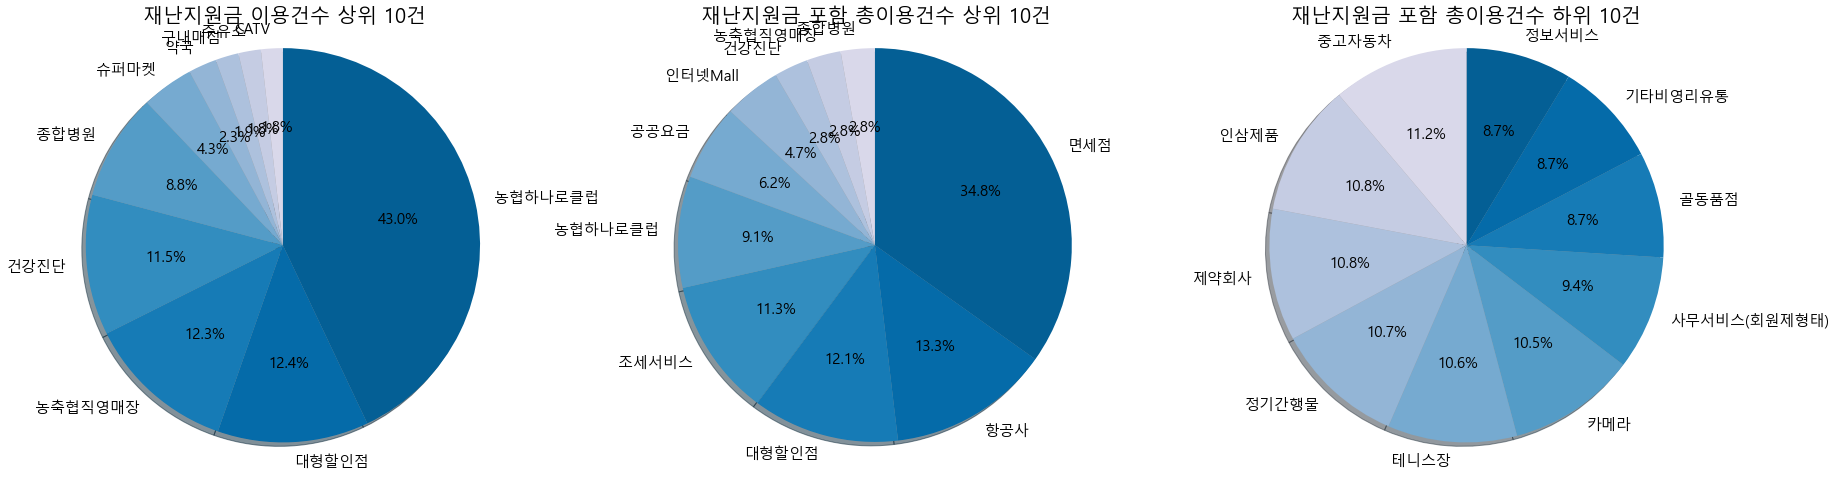

In [101]:
figure, (ax1,ax2,ax3) = plt.subplots(figsize=(20,10), ncols=3)
figure.set_size_inches(30,8)

cmap = plt.get_cmap("PuBu")
colors = cmap(sorted(np.arange(13)*18,reverse=True))

#재난지원금 이용건수 상위 10건
ax1.pie(type_num_max,labels=type_num_max.index, autopct='%1.1f%%', #데이터,라벨,퍼센티지 출력
        shadow=True, startangle=90, counterclock=False,colors=colors,textprops={'size':15}) #그림자, 시작점(90도), 색상, 크기
ax1.axis('equal')
ax1.set_title('재난지원금 이용건수 상위 10건',fontsize=20)

#재난지원금 포함 총이용건수 상위 10건
ax2.pie(type_dis_max,labels=type_dis_max.index, autopct='%1.1f%%',
        shadow=True, startangle=90, counterclock=False,colors=colors,textprops={'size':15})
ax2.axis('equal')
ax2.set_title('재난지원금 포함 총이용건수 상위 10건',fontsize=20)

#재난지원금 포함 총이용건수 하위 10건
ax3.pie(type_dis_min,labels=type_dis_min.index, autopct='%1.1f%%',
        shadow=True, startangle=90, counterclock=False,colors=colors,textprops={'size':15})
ax3.axis('equal')
ax3.set_title('재난지원금 포함 총이용건수 하위 10건',fontsize=20)

#### 마트, 병원 등 실생활에 반드시 필요한 시설에서 주로 사용되었다.
#### 새로운 소비를 부추기기 보다는 기존 소비를 도왔다고 해석 된다.

#### 월별 총 사용금액과 월별 재난지원금 총 사용금액 

Text(0.5, 1.0, '월별 총 재난지원금 사용금액')

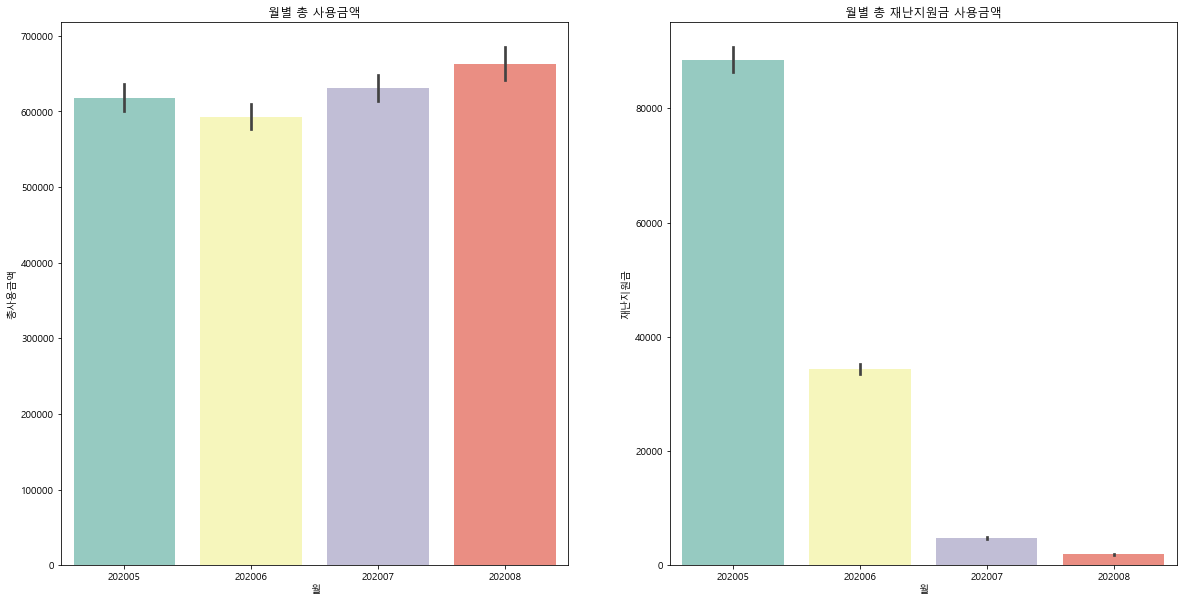

In [84]:
# 월별 총 사용금액과 월별 재난지원금 총 사용금액 

figure, ax = plt.subplots(ncols=2, figsize=(20,10))
#ax를 1,2,3... 으로 입력하는 방법과 출력할 때 ax[] 이렇게 입력하는 방법이 있음
#후자가 편한 듯

ym_num=sns.barplot(data=total, x="월", y="총사용금액", ax=ax[0] ,palette='Set3')
ym_num.set_title('월별 총 사용금액')

ym_dis=sns.barplot(data=total, x="월", y="재난지원금", ax=ax[1], palette='Set3')
ym_dis.set_title('월별 총 재난지원금 사용금액')

#제주도의 월별 사용금액은 월별로 큰 차이가 없으나, 재난지원금은 5월에 주로 사용되었음

#### 월별 총사용금액은 크지 않으나 재난지원금은 지원 당시인 5월에 가장 많이 사용된 것으로 나타난다.

#### 총사용금액에 비해 재난지원금은 얼마나 사용되었는지 확인

In [113]:
#총사용금액에 비해 재난지원금은 얼마나 사용되었는지 확인

#월별로 그룹화한 후 정리
total_num = total.groupby('월')['총사용금액'].sum() #월별 총사용금액 합계
total_dis = total.groupby('월')['재난지원금'].sum() #월별 재난지원금 합계

total_ym_money=total_num+total_dis

total_ym = total_num/total.총사용금액.sum() #전체 총사용금액 합계에 월별 합계를 나누기
total_money = total_dis/total_num #월별 총사용금액 합계에 월별 재난지원금 합계 나누기

month=['202005','202006','202007','202008']

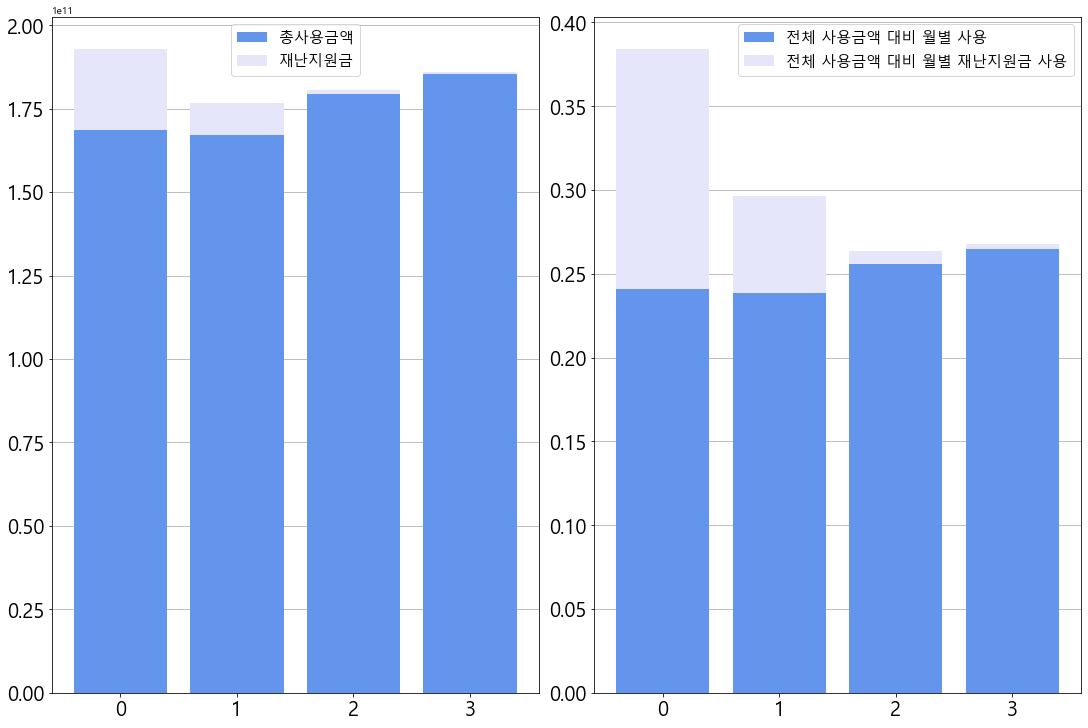

In [140]:
figure, (ax1,ax2) = plt.subplots(ncols=2, constrained_layout=True)
figure.set_size_inches(15,10)

ax1.set_axisbelow(True) #그래프 뒤에 바 그리기
ax1.grid(True, axis='y') #y축만 그리드

ax2.set_axisbelow(True)
ax2.grid(True, axis='y')

ax1.bar(range(len(total_num)), total_num, label='총사용금액', color='cornflowerblue') 
ax1.bar(range(len(total_dis)), total_dis, bottom=total_num,label='재난지원금', color='lavender')
ax1.tick_params(axis = 'x', labelsize = 20)
ax1.tick_params(axis = 'y', labelsize = 20)
plt.legend(['월별 총사용금액 합계', '월별 재난지원금 합계'])
ax1.legend(fontsize = 15)

ax2.bar(range(len(total_ym)), total_ym, label='전체 사용금액 대비 월별 사용', color='cornflowerblue') 
ax2.bar(range(len(total_money)), total_money, bottom=total_ym,label='전체 사용금액 대비 월별 재난지원금 사용', color='lavender')
ax2.tick_params(axis = 'x', labelsize = 20)
ax2.tick_params(axis = 'y', labelsize = 20)
plt.legend(['전체 사용금액 대비 월별 사용', '전체 사용금액 대비 월별 재난지원금 사용'])
ax2.legend(fontsize = 15)

#### 카드를 포함한 총사용금액은 8월이 가장 많지만 그에 반해 재난지원금 사용은 5월이 가장 높게 나타났다.
#### 제주도민이 아닌 일반 관광객의 소비로 인한 현상으로 보인다.

#### 전체 기간의 소비 대비 재난지원금 사용비율

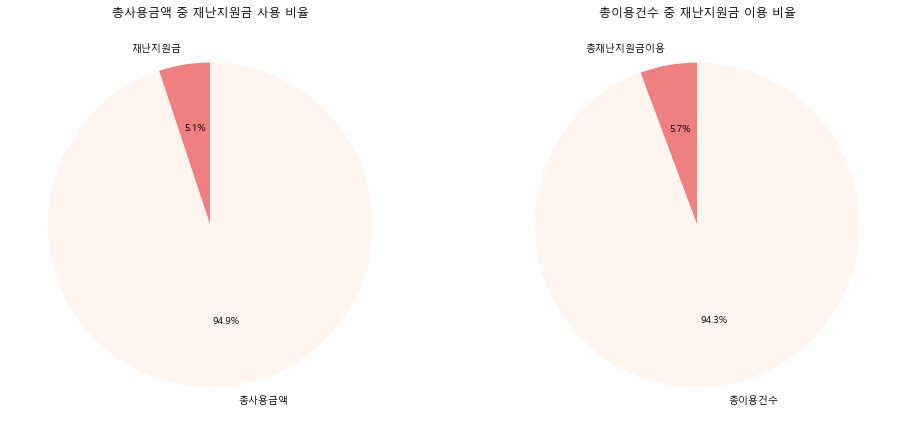

In [206]:
# 전체 기간의 소비 대비 재난지원금 사용비율

fig = plt.figure(figsize=(16,12))

labels1=['재난지원금','총사용금액']
labels2=['총재난지원금이용','총이용건수']

num_div_dis=total.재난지원금.mean()*100/total.총사용금액.mean()
num_div_dis_spent=total.총재난지원금이용.mean()*100/total.총이용건수.mean()


ax1 = fig.add_subplot(1,2,1)
title1 = "총사용금액 중 재난지원금 사용 비율"
ratio1 = [num_div_dis, 100-(num_div_dis)] 
a=ax1.pie(ratio1,labels=labels1, autopct='%1.1f%%', startangle=90, colors=['lightcoral','seashell'])
ax1= plt.title(title1)

ax2 = fig.add_subplot(1,2,2)
title2 = "총이용건수 중 재난지원금 이용 비율"
ratio2 = [num_div_dis_spent, 100-(num_div_dis_spent)] 
b=ax2.pie(ratio2,labels=labels2, autopct='%1.1f%%', startangle=90, colors=['lightcoral','seashell'])
ax2 = plt.title(title2)

#튜플 형식은 set.title 사용 불가


#### 사용금액과 이용건수 모두 전체에 비해선 미비한 경향을 보인다.

#### 월/업종별 상위 10개 항목

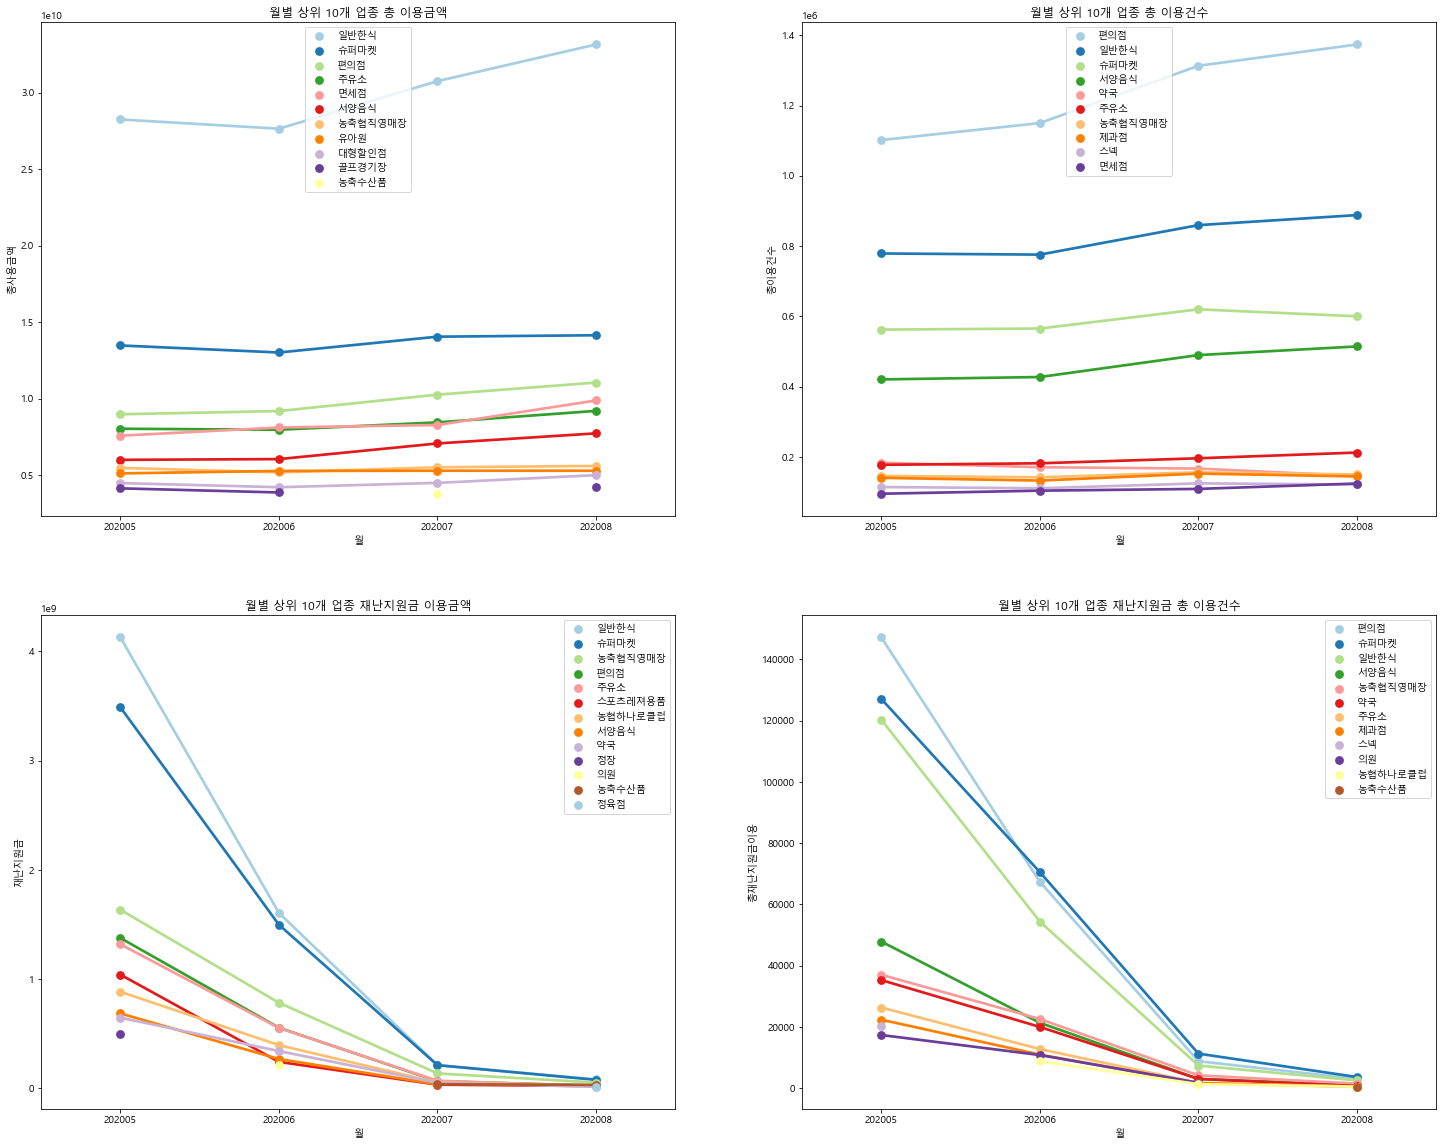

In [149]:
# 월별, 업종별로 각각 총 이용건수와 이용금액으로, 총 재난지원금 이용건수와 재난지원금 사용금액으로 그룹화
# 여러개의 함수를 여러 열에 적용 : agg()함수
# 모든열에 여러 함수를 매핑 : group객체.agg([함수1,함수2,함수3,…])
# 각 열마다 다른 함수를 매핑 : group객체.agg({‘열1’: 함수1, ‘열2’:함수2, …})
# legend(loc='best') 최적의 위치에 범례 지정

total_spent = total.groupby(['월', '업종']).agg({'총사용금액': sum, '총이용건수': sum, '재난지원금': sum, '총재난지원금이용': sum})

fig, ax = plt.subplots(ncols=2, nrows=2,  figsize=(25,20))

type10 = sns.pointplot(x='월', y='총사용금액', hue='업종', data=total_spent['총사용금액'].groupby('월', group_keys=False).nlargest(10).reset_index(), palette='Paired', ax=ax[0,0])
type10.set_title('월별 상위 10개 업종 총 이용금액')
type10.legend(loc='best')

num10 = sns.pointplot(x='월', y='총이용건수', hue='업종', data=total_spent['총이용건수'].groupby('월', group_keys=False).nlargest(10).reset_index(), palette='Paired', ax=ax[0,1])
num10.set_title('월별 상위 10개 업종 총 이용건수')
num10.legend(loc='best')

dis10 = sns.pointplot(x='월', y='재난지원금', hue='업종', data=total_spent['재난지원금'].groupby('월', group_keys=False).nlargest(10).reset_index(), palette='Paired', ax=ax[1,0])
dis10.set_title('월별 상위 10개 업종 재난지원금 이용금액')
dis10.legend(loc='best')

numdis10 = sns.pointplot(x='월', y='총재난지원금이용', hue='업종', data=total_spent['총재난지원금이용'].groupby('월', group_keys=False).nlargest(10).reset_index(), palette='Paired', ax=ax[1,1])
numdis10.set_title('월별 상위 10개 업종 재난지원금 총 이용건수')
numdis10.legend(loc='best')

#### 재난지원금과 일반 거래 모두 편의점과 일반한식이 월등하게 높은 결과가 나타났다.
#### 일반 거래는 점진적으로 상승한 것에 비해 재난지원금 사용은 확연하게 사용률이 낮아진다.
#### 5월 지급 직후 대부분의 거래가 이루어진 것으로 보인다.

#### 시간별 상위 10개 항목

Text(0.5, 0.98, '시간별 상위 10개 항목')

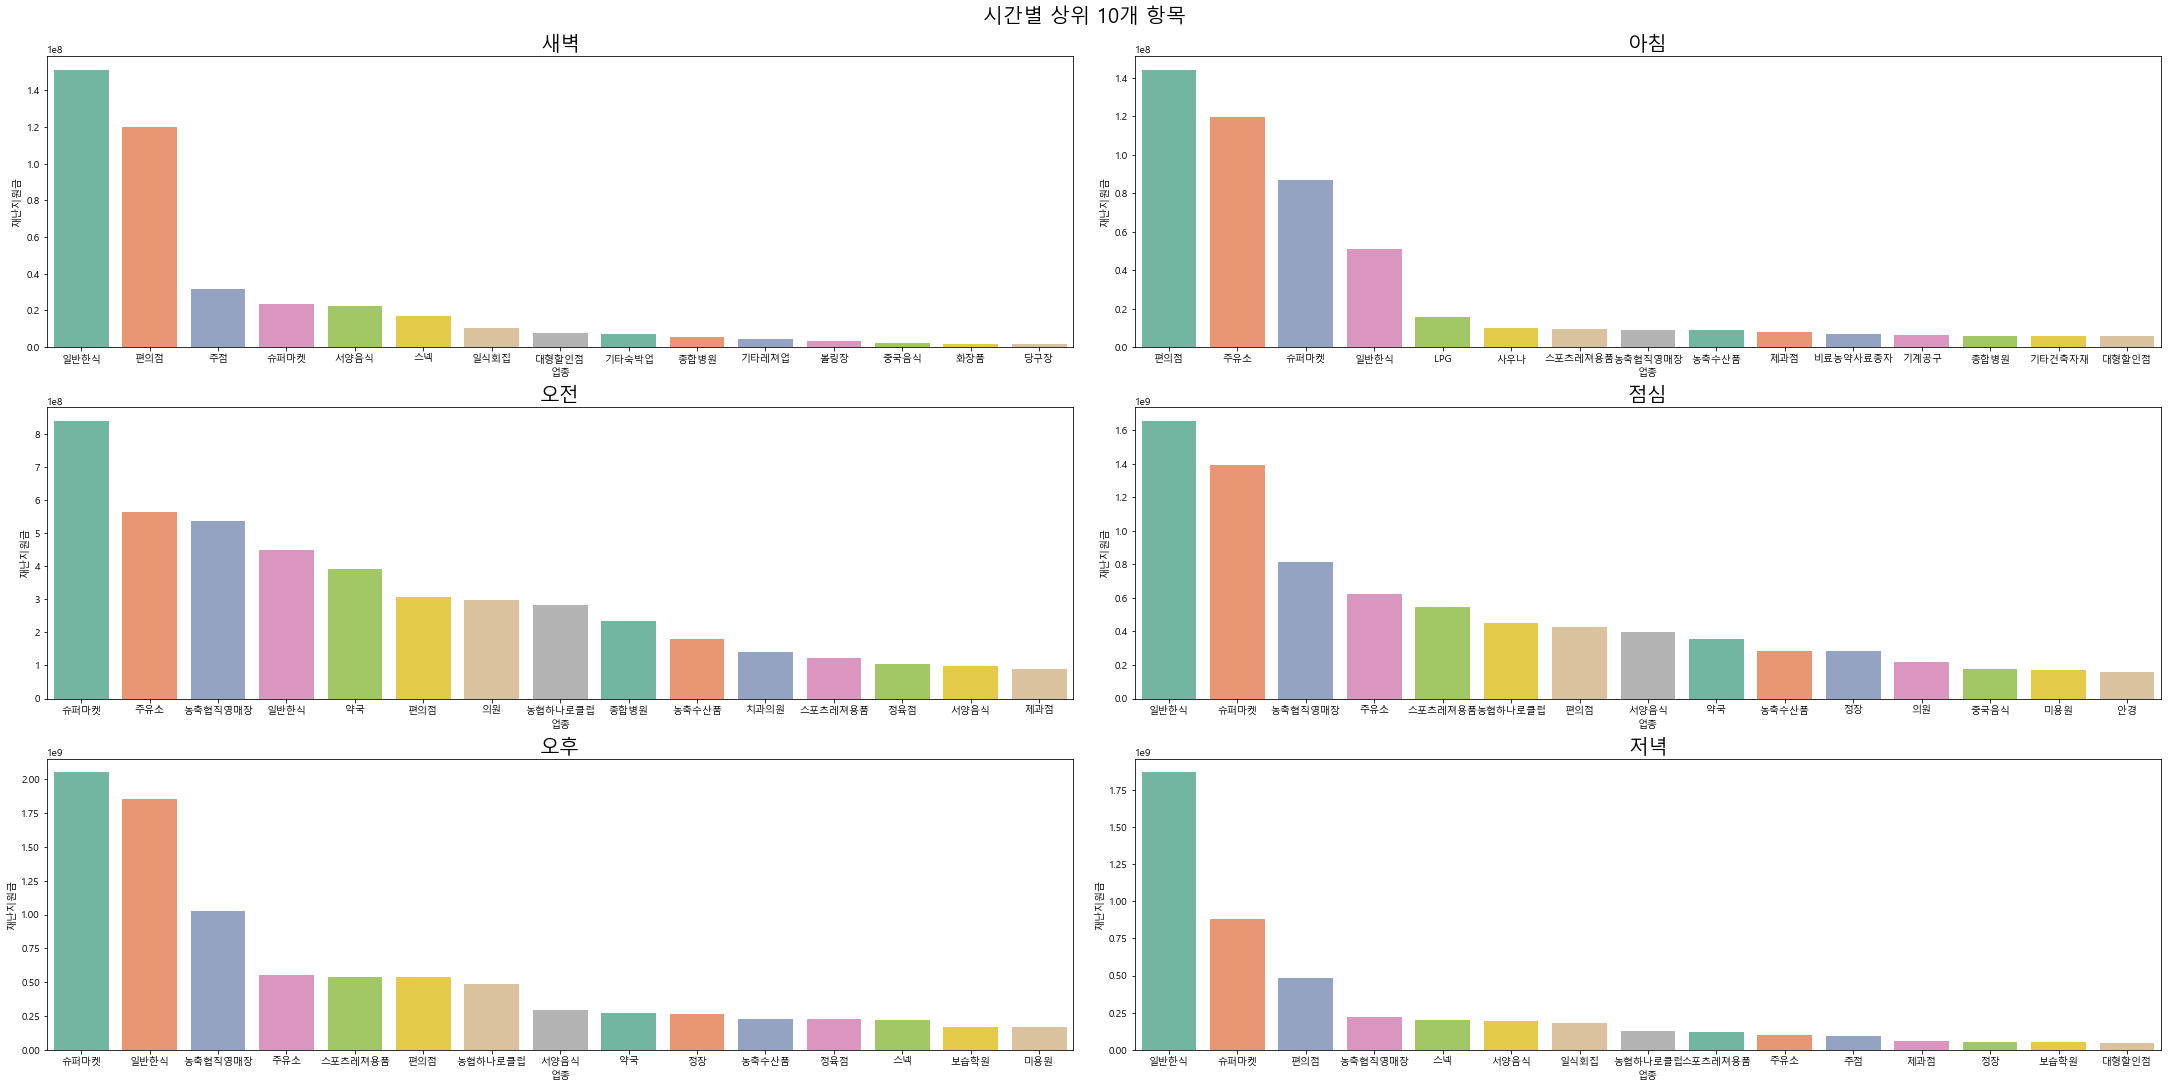

In [18]:
total_time=[]

for i in list(('새벽', '아침', '오전', '점심', '오후', '저녁')):   
    time_type=total.groupby(['시간_분배','업종'])['재난지원금'].sum()
    time_type=pd.DataFrame(time_type).sort_values('재난지원금', ascending=False)
    time_type.reset_index(inplace=True)
    total_time.append(time_type[time_type['시간_분배']==i].reset_index(drop=True).head(15))

total_time_type = pd.concat(total_time, axis=0)
figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
figure.set_size_inches(30,15)

sns.barplot(data=total_time_type[total_time_type['시간_분배']=='새벽'],  x="업종", y="재난지원금", ax=ax1, palette='Set2')  
ax1.set_title("새벽", fontsize=20)

sns.barplot(data=total_time_type[total_time_type['시간_분배']=='아침'],  x="업종", y="재난지원금", ax=ax2, palette='Set2')
ax2.set_title("아침", fontsize=20)

sns.barplot(data=total_time_type[total_time_type['시간_분배']=='오전'],  x="업종", y="재난지원금", ax=ax3, palette='Set2') 
ax3.set_title("오전", fontsize=20)

sns.barplot(data=total_time_type[total_time_type['시간_분배']=='점심'],  x="업종", y="재난지원금", ax=ax4, palette='Set2')  
ax4.set_title("점심", fontsize=20)

sns.barplot(data=total_time_type[total_time_type['시간_분배']=='오후'],  x="업종", y="재난지원금", ax=ax5, palette='Set2')  
ax5.set_title("오후", fontsize=20)

sns.barplot(data=total_time_type[total_time_type['시간_분배']=='저녁'],  x="업종", y="재난지원금", ax=ax6, palette='Set2')
ax6.set_title("저녁", fontsize=20)

plt.suptitle('시간별 상위 10개 항목' ,fontsize=20)

#### 식사시간대에는 일반한식이 높게 나타나고, 그외의 시간대는 모두 편의점이 가장 재난지원금 사용률이 높았다.
#### 대부분의 재난지원금이 일상에서 필수적인 식당, 병원 등에서 사용되는 것으로 나타났다.

#### 기간별 순위가 높은 일반한식, 편의점과 약국, 의원을 시간별로 분석해보았다.

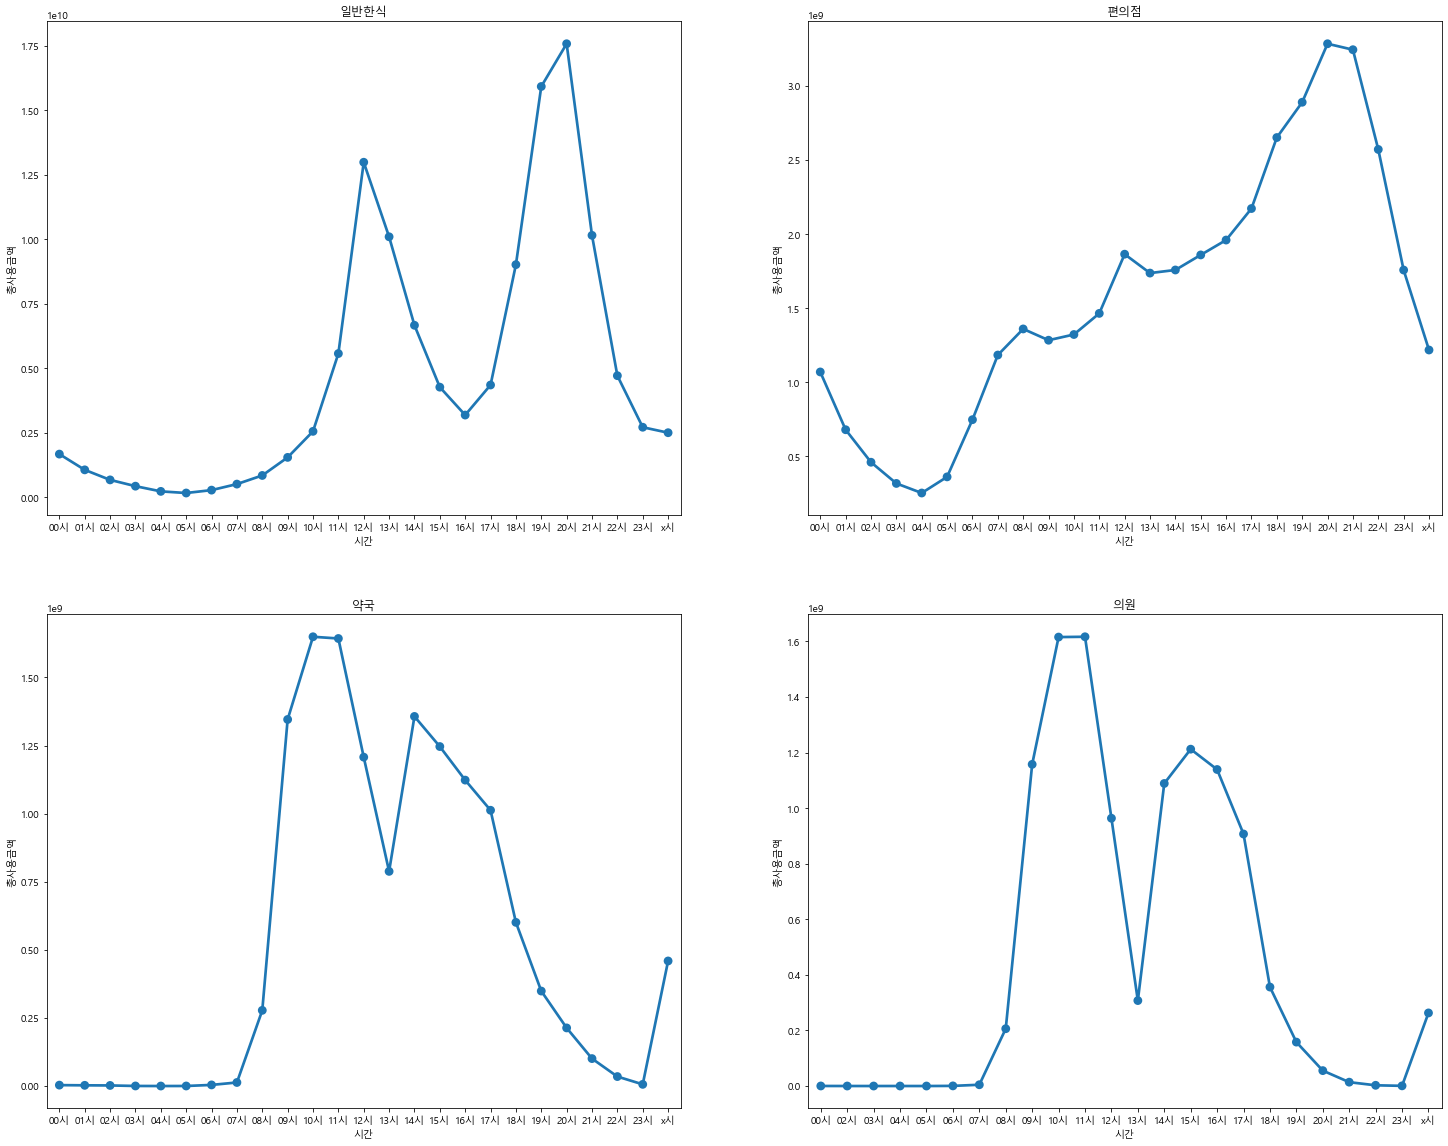

In [18]:
fig, ax = plt.subplots(ncols=2, nrows=2,  figsize=(25,20))

ax1 = sns.pointplot(x='시간', y='총사용금액', data=total[(total['업종'] == '일반한식')].groupby(['업종','시간'])['총사용금액'].sum().reset_index(), ax=ax[0,0])
ax1.set_title('일반한식')

ax2 = sns.pointplot(x='시간', y='총사용금액', data=total[(total['업종'] == '편의점')].groupby(['업종','시간'])['총사용금액'].sum().reset_index(), ax=ax[0,1])
ax2.set_title('편의점')

ax3 = sns.pointplot(x='시간', y='총사용금액', data=total[(total['업종']== '약국')].groupby(['업종','시간'])['총사용금액'].sum().reset_index(), ax=ax[1,0])
ax3.set_title('약국')

ax4 = sns.pointplot(x='시간', y='총사용금액', data=total[(total['업종'] == '의원')].groupby(['업종','시간'])['총사용금액'].sum().reset_index(), ax=ax[1,1])
ax4.set_title('의원')

fig.show()

#### 일반한식과 편의점 모두 식사시간대에 사용률이 높지만 특히 편의점은 야간에 사용률이 높았다.
#### 제주도의 마트가 대부분 일찍 영업을 종료해서 그런 것으로 추측된다.
#### 의원과 약국은 소비 추세가 거의 비슷한 것으로 나타났다.

#### 시간별 총거래량과 재난지원금 이용건수

<AxesSubplot:xlabel='시간_분배', ylabel='총재난지원금이용'>

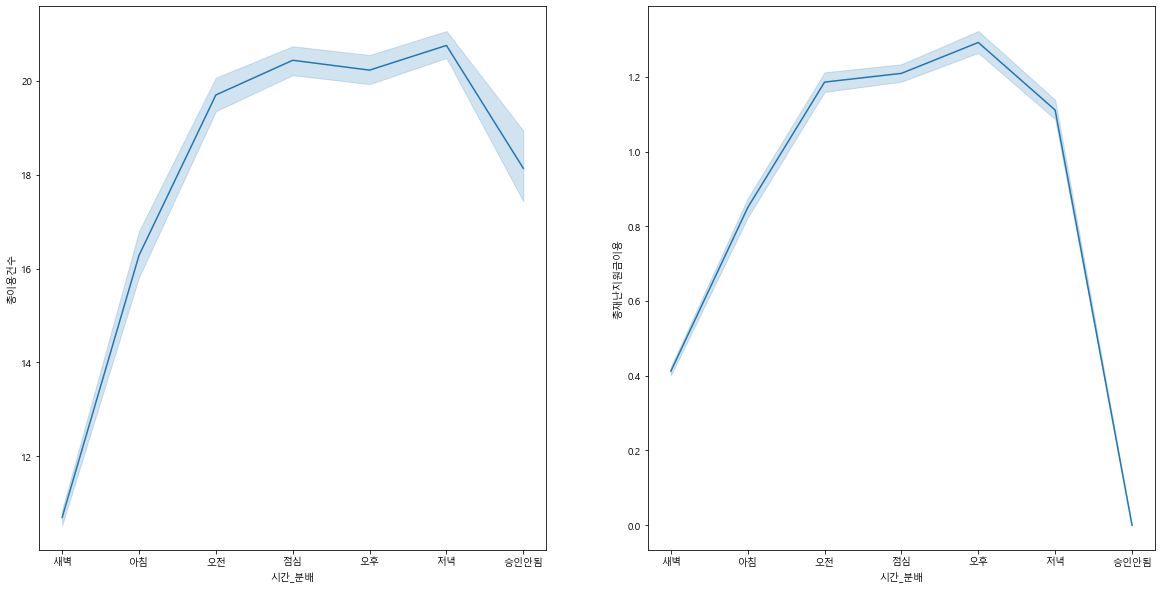

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

sns.lineplot(data=total, palette='Spectral', y='총이용건수', x='시간_분배', ax=ax[0])
sns.lineplot(data=total, palette='Spectral', y='총재난지원금이용', x='시간_분배', ax=ax[1])

#### 시간대는 일반거래와 재난지원금 모두 점심/오후가 높은 것으로 나타난다.
#### 재난지원금은 승인되지 않은 거래가 없기 때문에 0으로 표시된다.

#### 월/업종별 총이용건수과 총재난지원금이용건수 비교

In [40]:
total['count'] = 1

In [41]:
num_5 = total[total['월'] == 202005].groupby(['업종'], as_index=False).agg({'count': sum, '총이용건수': sum, '총재난지원금이용': sum}).sort_values(by='count', ascending=False).head(10)
num_6 = total[total['월'] == 202006].groupby(['업종'], as_index=False).agg({'count': sum, '총이용건수': sum, '총재난지원금이용': sum}).sort_values(by='count', ascending=False).head(10)
num_7 = total[total['월'] == 202007].groupby(['업종'], as_index=False).agg({'count': sum, '총이용건수': sum, '총재난지원금이용': sum}).sort_values(by='count', ascending=False).head(10)
num_8 = total[total['월'] == 202008].groupby(['업종'], as_index=False).agg({'count': sum, '총이용건수': sum, '총재난지원금이용': sum}).sort_values(by='count', ascending=False).head(10)

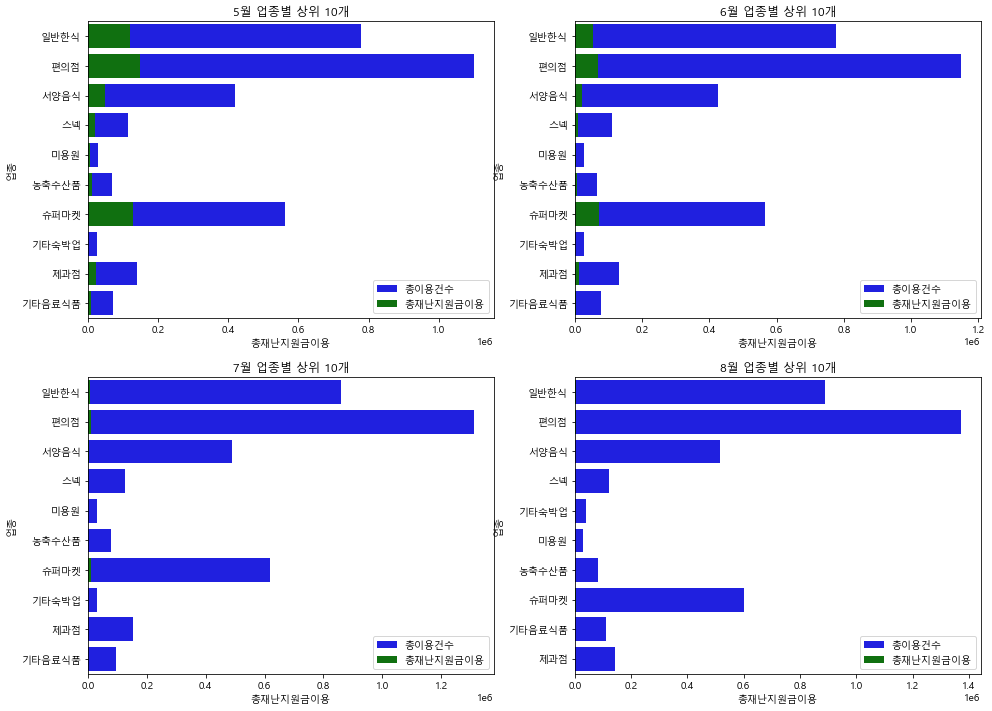

In [42]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.barplot(x='총이용건수', y='업종', data=num_5, label='총이용건수', color='b')
ax1 = sns.barplot(x='총재난지원금이용', y='업종', data=num_5, label='총재난지원금이용', color='g')
ax1.legend(loc='best', frameon=True)
ax1.set_title('5월 업종별 상위 10개')

ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.barplot(x='총이용건수', y='업종', data=num_6, label='총이용건수', color='b')
ax2 = sns.barplot(x='총재난지원금이용', y='업종', data=num_6, label='총재난지원금이용', color='g')
ax2.legend(loc='best', frameon=True)
ax2.set_title('6월 업종별 상위 10개')

ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.barplot(x='총이용건수', y='업종', data=num_7, label='총이용건수', color='b')
ax3 = sns.barplot(x='총재난지원금이용', y='업종', data=num_7, label='총재난지원금이용', color='g')
ax3.legend(loc='best', frameon=True)
ax3.set_title('7월 업종별 상위 10개')

ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.barplot(x='총이용건수', y='업종', data=num_8, label='총이용건수', color='b')
ax4 = sns.barplot(x='총재난지원금이용', y='업종', data=num_8, label='총재난지원금이용', color='g')
ax4.legend(loc='best', frameon=True)
ax4.set_title('8월 업종별 상위 10개')
plt.show()

#### 재난지원금 사용이 낮아지는 7,8월에서는 찾아보기 어려우나,
#### 재난지원금 이용이 많은 5,6월에는 다른 항목의 총이용건수에 비해 슈퍼마켓이 재난지원금 이용이 높은 것으로 나타난다.
#### 농협하나로마트와 같은 대형마트가 아닌 일반마트에서 총이용건수 대비 재난지원금 사용률이 높은 것으로 보인다.

#### 재난지원금 소상공인별 사용 현황 금액 및 사용건수

Text(0.5, 1.0, '소상공인 시간대별 재난지원금 사용 건수 현황')

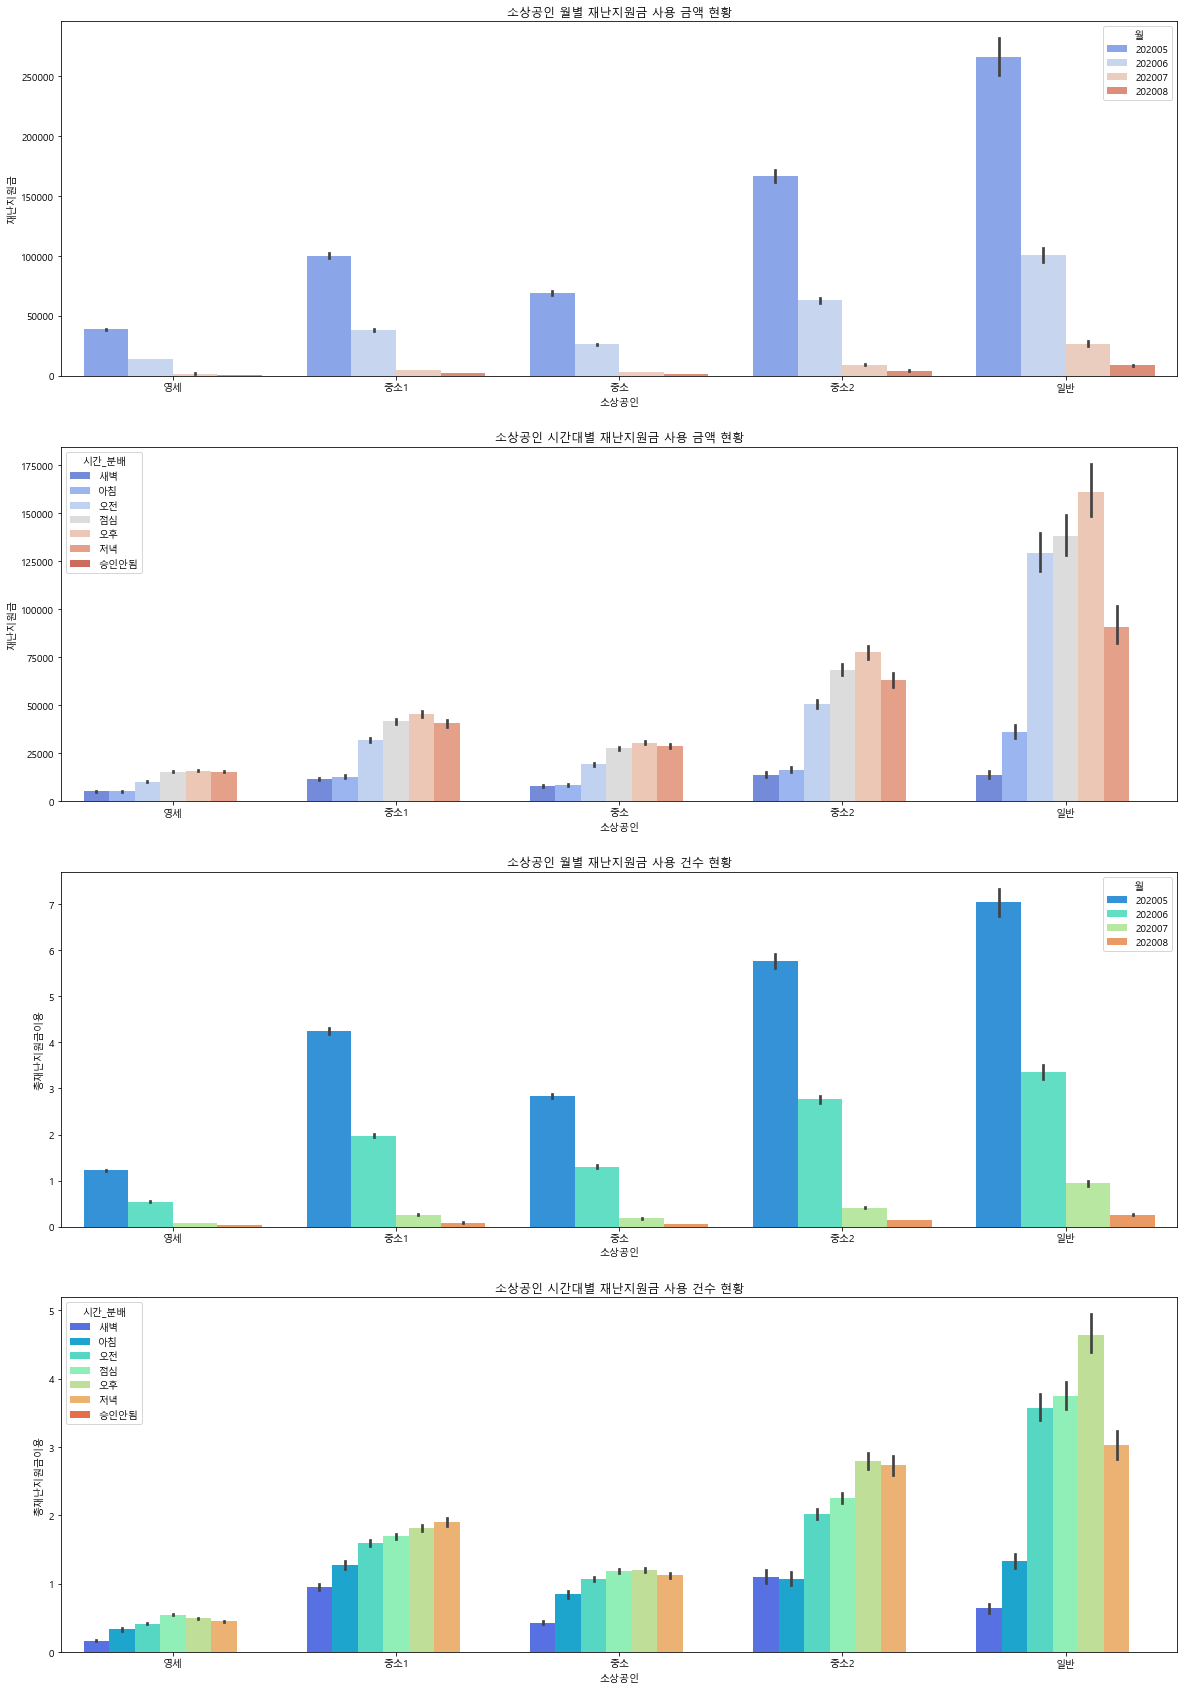

In [116]:
#재난지원금 소상공인별 사용 현황 금액 및 사용건수

fig, ax = plt.subplots(nrows=4, figsize=(20,30))

fran_money=sns.barplot(data=total, palette='coolwarm', y='재난지원금', x='소상공인', hue='월', ax=ax[0])
fran_money.set_title("소상공인 월별 재난지원금 사용 금액 현황")

fran_time=sns.barplot(data=total, palette='coolwarm', y='재난지원금', x='소상공인', hue='시간_분배', ax=ax[1])
fran_time.set_title("소상공인 시간대별 재난지원금 사용 금액 현황")

fran_num=sns.barplot(data=total, palette='rainbow', y='총재난지원금이용', x='소상공인', hue='월', ax=ax[2])
fran_num.set_title("소상공인 월별 재난지원금 사용 건수 현황")

fran_num_time=sns.barplot(data=total, palette='rainbow', y='총재난지원금이용', x='소상공인', hue='시간_분배', ax=ax[3])
fran_num_time.set_title("소상공인 시간대별 재난지원금 사용 건수 현황")

#월별 사용금액과 시간별 사용금액이 비슷한 추이를 보인다.
#재난지원금 사용 금액은 월, 시간대 모두 일반기업의 사용량이 가장 많고, 영세업자의 사용량이 가장 낮은 것으로 나타난다

#### 일반기업에서 일반거래와 재난지원금 사용금액 및 거래량 모두 가장 높게 나타났다.
#### 이 그래프만 보고 일반기업의 수가 영세업자보다 높을 것이라 예상하고 실제 수를 구해보았다.

In [ ]:
# total['소상공인'].value_counts()
"""영세     639337
중소     140999
중소1    136904
일반     122327
중소2     79862"""

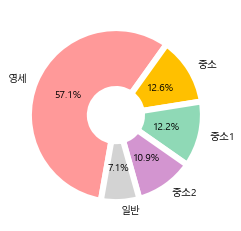

In [113]:
fran = ['영세', '중소', '중소1', '중소2','일반']
values = [639337, 140999, 136904, 122327,79862]
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0', 'lightgray']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 6}

plt.pie(values, labels=fran, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)
plt.show()

#재난지원금 소상공인별 사용 현황 금액 및 사용건수를 확인 후 일반이 가장 많을 것이라 예상했으나 영세가 가장 많은 것으로 나타났다.

#### 재난지원금 소상공인별 사용 현황 금액 및 사용건수를 확인 후 일반이 가장 많을 것이라 예상했으나 영세가 가장 많은 것으로 나타났다.

#### 지역별 재난지원금 사용 현황

<AxesSubplot:xlabel='시군구', ylabel='재난지원금'>

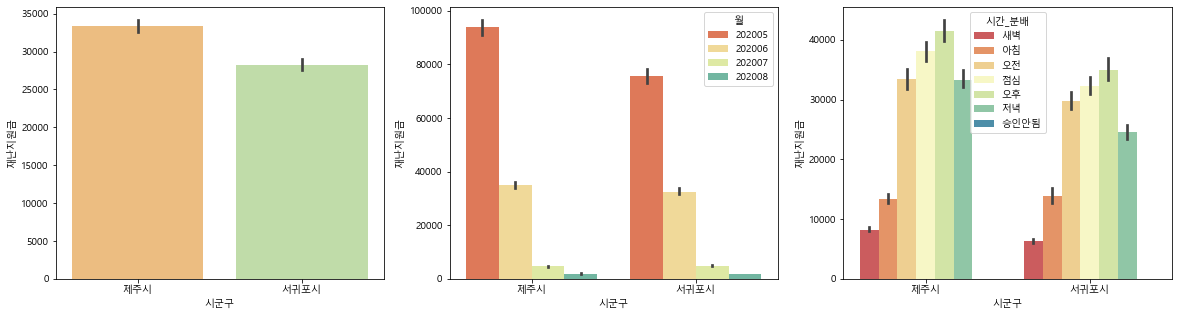

In [11]:
#지역별 재난지원금 사용 현황

fig, ax = plt.subplots(ncols=3, figsize=(20,30))

sns.barplot(data=total, palette='Spectral', y='재난지원금', x='시군구', ax=ax[0])
sns.barplot(data=total, palette='Spectral', y='재난지원금', x='시군구', hue='월', ax=ax[1])
sns.barplot(data=total, palette='Spectral', y='재난지원금', x='시군구', hue='시간_분배', ax=ax[2])

#제주시의 사용량이 서귀포시보다 높고(제주시 인구 밀도가 높아서 그런 것으로 추측), 기간별 사용량은 비슷함)

#### 제주시의 거래량이 서귀포시보다 높아서 제주시의 인구가 서귀포시보다 높을 것이라 예상하였다.

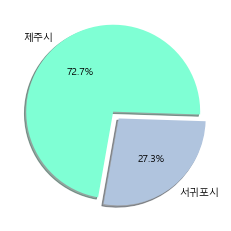

In [16]:
# * 총 인구 : 697,578명 (내국인 : 674,635명, 외국인 : 22,943명)
# - 제주시 총 인구 : 507,358명 (내국인 : 492,466명, 외국인 : 14,892명)
# - 서귀포시 총 인구 : 190,220명 (내국인 : 182,169명, 외국인 : 8,051명)

ratio = [507358, 190220]
labels = ['제주시','서귀포시']
colors=['aquamarine','lightsteelblue']
explode = [0.05, 0.05]

plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors)
plt.show()

#### 실제로 제주시의 인구는 서귀포시 인구의 거의 3배이다.
#### 인구수에 비해서는 제주시에서의 재난지원금 사용량이 그리 높지 않은 것으로 보인다.
#### 위의 그래프를 보고 재난지원금을 포함한 일반 거래량 또한 제주시가 더 높을 것으로 예상했다.

#### 지역별 재난지원금을 포함한 총사용금액을 확인

<AxesSubplot:xlabel='시군구', ylabel='총사용금액'>

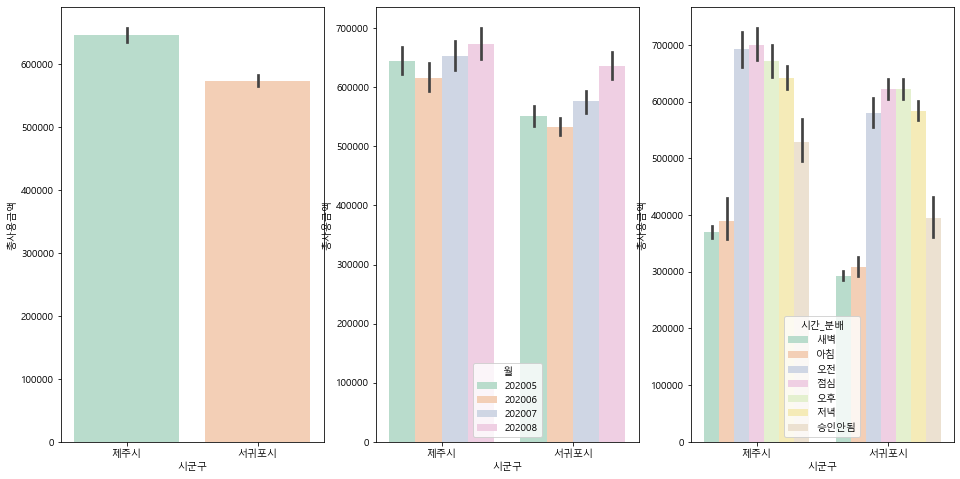

In [23]:
#지역별 일반거래 사용 현황

fig, ax = plt.subplots(ncols=3, figsize=(16,8))

sns.barplot(data=total, palette='Pastel2', y='총사용금액', x='시군구', ax=ax[0])
sns.barplot(data=total, palette='Pastel2', y='총사용금액', x='시군구', hue='월', ax=ax[1])
sns.barplot(data=total, palette='Pastel2', y='총사용금액', x='시군구', hue='시간_분배', ax=ax[2])
fig.show()

#### 각 시에서 일반거래/재난지원금 사용 상위 10개 읍면동을 확인

In [53]:
#시,도,읍면동이 다 나오면 그래프가 복잡해져서 '읍면동'만 나오는 열 생성
def text_d(x) :
    if str(x).find("시"):
        s=str(x).split(" ")[2]
        s=''.join(s)
    return s

In [54]:
total_dong['읍면동만'] = total_dong['읍면동'].apply(text_d)

In [55]:
total_dong['읍면동만']

0         한경면
1         한경면
2         한경면
3         한경면
4         한경면
         ... 
15364     성산읍
15365     한림읍
15366     내도동
15367     오등동
15368    이도이동
Name: 읍면동만, Length: 15369, dtype: object

In [56]:
jejucity=total_dong[total_dong['시군구']=='제주시']
sgcity=total_dong[total_dong['시군구']=='서귀포시']

Text(0.5, 1.0, '서귀포시 총 재난지원금 이용 상위 10개 읍면동')

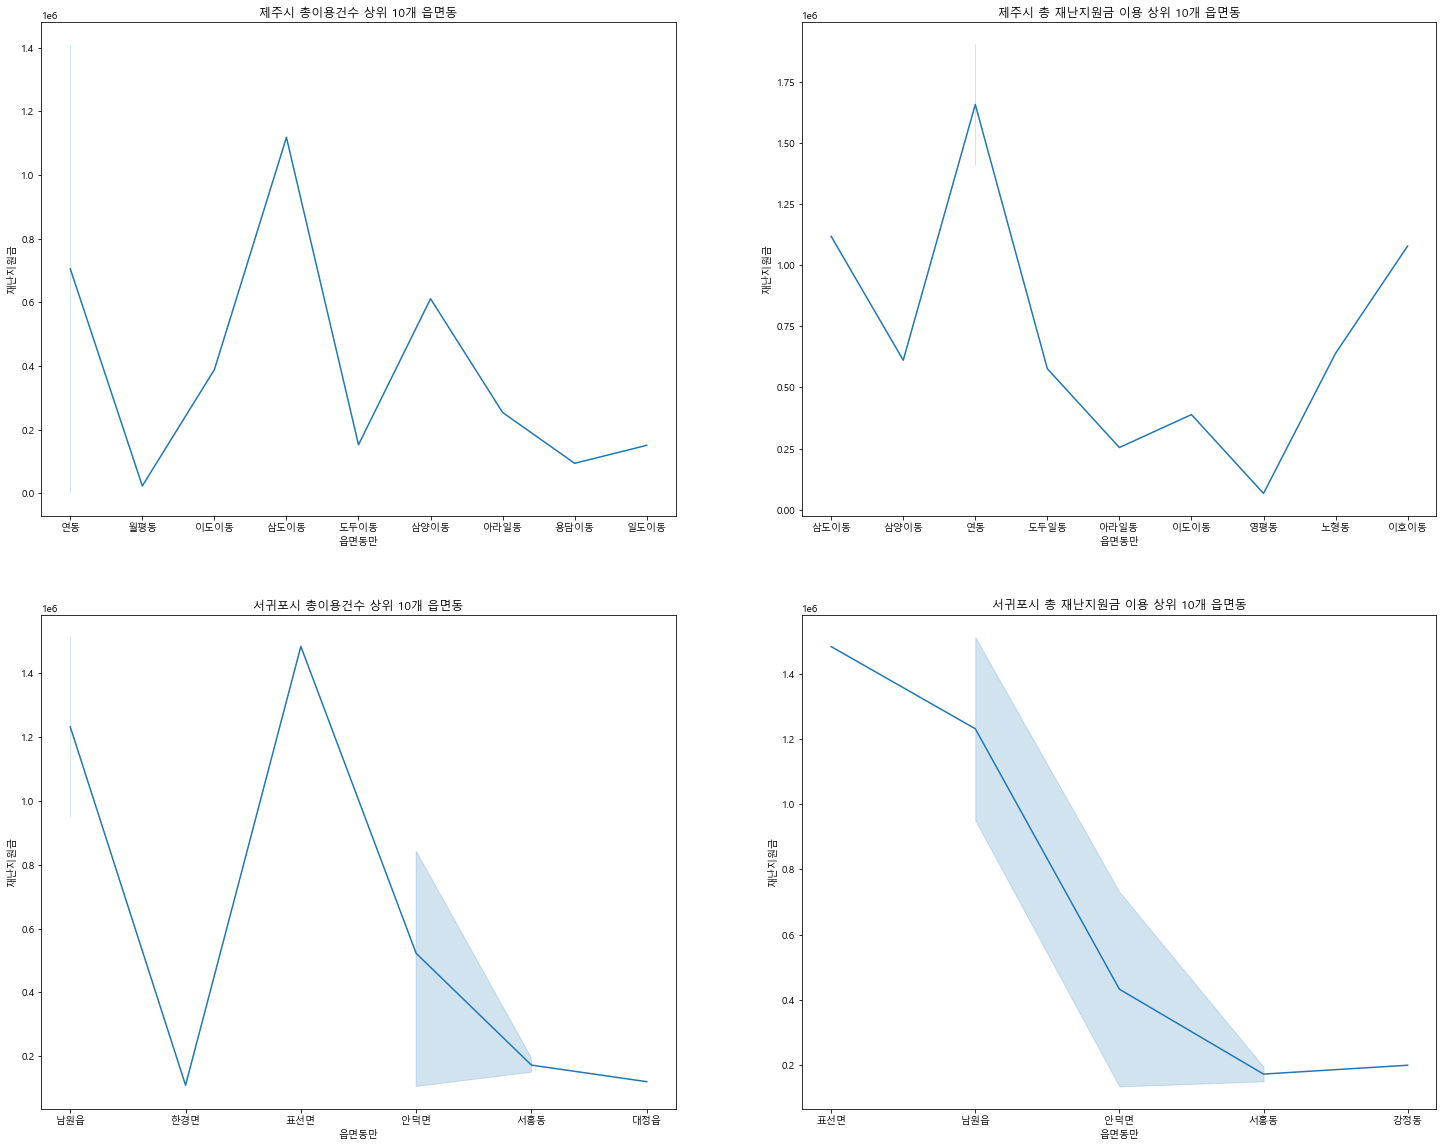

In [153]:
fig, ax = plt.subplots(ncols=2, nrows=2,  figsize=(25,20))

jejucity_num=sns.lineplot(data=jejucity.nlargest(10,'총이용건수'), palette='green', y='재난지원금', x='읍면동만', ax=ax[0,0])
jejucity_num.set_title('제주시 총이용건수 상위 10개 읍면동')

jejucity_dis=sns.lineplot(data=jejucity.nlargest(10,'총재난지원금이용'), palette='Spectral', y='재난지원금', x='읍면동만', ax=ax[0,1])
jejucity_dis.set_title('제주시 총 재난지원금 이용 상위 10개 읍면동')

sgcity_num=sns.lineplot(data=sgcity.nlargest(10,'총이용건수'), palette='Spectral', y='재난지원금', x='읍면동만', ax=ax[1,0])
sgcity_num.set_title('서귀포시 총이용건수 상위 10개 읍면동')

sgcity_dis=sns.lineplot(data=sgcity.nlargest(10,'총재난지원금이용'), palette='Spectral', y='재난지원금', x='읍면동만', ax=ax[1,1])
sgcity_dis.set_title('서귀포시 총 재난지원금 이용 상위 10개 읍면동')

#### 제주시에서는 삼도이동이 총거래량은 가장 많은 반면, 재난지원금은 연동이 가장 많은 것으로 나타났다.
#### 서귀포시에서는 표선면이 총거래량과 재난지원금 이용량 모두 가장 높게 나타났다.

### 인스타그램에서 '재난지원금' 정보 가져오기
#### 위치 : 제주도

#### 인스타그램에서 제주도는 다른 지역에서도 지정할 수 있음 -> 신뢰도가 낮음

In [80]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import re
from selenium.webdriver.common.by import By
import datetime
from dateutil.relativedelta import relativedelta

In [81]:
driver=webdriver.Chrome("c:/chromedriver.exe")
driver.get("https://www.instagram.com")
time.sleep(2)

In [82]:
#검색어를 전달 받아 url 주소를 리턴해주는 함수
def instaSearching(word):
    url="http://www.instagram.com/explore/tags/"+ str(word)
    return url

In [83]:
#검색 후 첫번째 게시글 클릭
def select_first(driver):
    first = driver.find_elements(By.CSS_SELECTOR, "div._aagw")[0]
    first.click()
    html = driver.page_source
    time.sleep(3)

In [84]:
#datetime을 5/1 ~ 9/1까지(10/18 기준)
now_date = datetime.datetime.now()
before_two_years_start = now_date + relativedelta(years=-2) + relativedelta(months=-5) + relativedelta(days=-17)
before_two_years_end = now_date + relativedelta(years=-2) + relativedelta(months=-1) + relativedelta(days=-17)

before_two_years_end_1 = now_date + relativedelta(years=-2) + relativedelta(months=-1) + relativedelta(days=-16)

In [85]:
print(str(before_two_years_start))
print(str(before_two_years_end))
print(str(before_two_years_end_1))

2020-05-01 11:13:48.032403
2020-09-01 11:13:48.032403
2020-09-02 11:13:48.032403


In [86]:
#게시글, 태그, 날짜, 위치 추출
def get_content(driver):
    html=driver.page_source
    soup=BeautifulSoup(html, 'html.parser')
    
    try:
        content=soup.select('div._a9zr>div._a9zs>span')[0].text
    except:
        content=''
        
    tags=re.findall('#.+', content)
    
    try:
        place=soup.select('div._aaqm')[0].text
    except:
        place=''
        
    date=soup.select('time._aaqe')[0]['datetime'][:10]
    if before_two_years_end < before_two_years_end_1 :
        # 20200901을 지나면 x
        date=''
        place=''
        content=''
        tags=''

    data=[content,tags,date,place]
    return data

In [87]:
#다음 페이지로 이동
def move_next(driver):
    right = driver.find_elements(By.CSS_SELECTOR, "div._aaqg._aaqh")
    right[0].click()
    html = driver.page_source
    time.sleep(3)

In [88]:
#로그인
email="아이디"
password="비밀번호"
input_box=driver.find_elements(By.CSS_SELECTOR , 'input._2hvTZ.pexuQ.zyHYP')
input_box[0].clear() # 아이디 박스
input_box[0].send_keys(email)
input_box[1].clear() # 비밀번호 박스
input_box[1].send_keys(password)
input_box[1].submit() #로그인(접속)
time.sleep(2)

In [244]:
# # 정보 나중에 저장하기 클릭하고 넘어가기
# driver.find_elements(By.CSS_SELECTOR, ' ').click()  
# time.sleep(3)

# # 알림설정 나중에하기 클릭하고 넘어가기
# driver.find_elements(By.CSS_SELECTOR, ' ').click()   
# time.sleep(3)

In [89]:
keyword="재난지원금"
url=instaSearching(keyword)
driver.get(url)
time.sleep(2)

In [35]:
select_first(driver)

In [90]:
results=[]

target=10

for i in range(target):
    
    try:
        data=get_content(driver)
        results.append(data)
        move_next(driver)
        
    except:
        time.sleep(2)
        move_next(driver)
    time.sleep(5)

    
print(results[:2])

In [75]:
word_re=[]
for i in results:
    word_re.append(i)

In [91]:
word_re

[['5,6월 푸릇한 메밀꽃밭, 보라유채꽃, 삼색버드나무 등 여러 꽃 만나볼 수 있는 곳 🌿🌳🌼 ⠀계절별로 피는 꽃이 달라 사계절내내 방문하기 좋고 ⠀농장이 넓어서 여기저기 구경하면서 산책하기 딱 좋은 🤍도깨비보고 메밀밭에 푹 빠졌었는데 원없이 보구왔지룬 \U0001faf6🏻⠀🏷 정보는 블로그에 ¨̮',
  [],
  '',
  '제주도'],
 ['#윤수in제주 #숙소협찬이번에 너무 좋은 기회로 제주 표선면에 위치한 숙소인 #표선여가 에 다녀왔어요 :)표선면은 주로 현지인이 살고 있는 동네라 다른 관광지보다 더 조용해서 고즈넉한 제주의 분위기를 만끽하실 수 있답니다! 특히 전 가을만이 주는 선선한 날씨를 무척 좋아하는 편인데, 해질녘 즈음 간절기 외투 하나 걸치고 이 동네를 산책하는 것이 이번 여행의 묘미 중 하나였어요ㅎㅎ공간 곳곳마다 담당자님의 섬세한 취향이 느껴졌던 아름다운 이곳! 앞으로 올라올 포스팅도 많은 기대 부탁드립니다 🤎🏡 @pyoseonyeoga',
  ['#윤수in제주 #숙소협찬이번에 너무 좋은 기회로 제주 표선면에 위치한 숙소인 #표선여가 에 다녀왔어요 :)표선면은 주로 현지인이 살고 있는 동네라 다른 관광지보다 더 조용해서 고즈넉한 제주의 분위기를 만끽하실 수 있답니다! 특히 전 가을만이 주는 선선한 날씨를 무척 좋아하는 편인데, 해질녘 즈음 간절기 외투 하나 걸치고 이 동네를 산책하는 것이 이번 여행의 묘미 중 하나였어요ㅎㅎ공간 곳곳마다 담당자님의 섬세한 취향이 느껴졌던 아름다운 이곳! 앞으로 올라올 포스팅도 많은 기대 부탁드립니다 🤎🏡 @pyoseonyeoga'],
  '',
  ''],
 ['*소금막해변 / 해변 주소 : 서귀포시 표선면 하천리 94-2#소금막해변 #소금막해수욕장 #표선해수욕장 #제주바다 #제주도바다 #제주관광 #제주도관광 #제주가볼만한곳 #제주도가볼만한곳 #제주그램 #제주도그램 #제주여행 #제주도여행 #제주앓이 #제주살이 #제주일상 #제주라이프 #jejudo #jeju #jejuisland #jejutrip #제주 #

#### 표선면의 총이용건수, 총재난지원금이용 월별 확인

In [61]:
sg5=sgcity[sgcity['월']==202005]
sg6=sgcity[sgcity['월']==202006]
sg7=sgcity[sgcity['월']==202007]
sg8=sgcity[sgcity['월']==202008]

In [64]:
sg5=sg5[sg5['읍면동만']=='표선면']
sg6=sg6[sg6['읍면동만']=='표선면']
sg7=sg7[sg7['읍면동만']=='표선면']
sg8=sg8[sg8['읍면동만']=='표선면']

In [63]:
sg5

,index,월,시군구,소상공인,업종,시간,총사용금액,재난지원금,총이용건수,총재난지원금이용,x,y,시간_분배,읍면동,읍면동만
2750,4646,202005,서귀포시,영세,유흥주점,00시,45000,0,3,0,126.789801,33.307599,새벽,제주특별자치도 서귀포시 표선면,표선면
2755,4652,202005,서귀포시,영세,편의점,00시,235630,11000,19,2,126.796755,33.309470,새벽,제주특별자치도 서귀포시 표선면,표선면
2756,4653,202005,서귀포시,중소1,편의점,00시,4500,0,1,0,126.797735,33.394683,새벽,제주특별자치도 서귀포시 표선면,표선면
2757,4654,202005,서귀포시,중소2,편의점,00시,15200,9000,3,1,126.798797,33.395595,새벽,제주특별자치도 서귀포시 표선면,표선면
2760,4659,202005,서귀포시,영세,골프경기장,00시,124000,0,2,0,126.818456,33.332669,새벽,제주특별자치도 서귀포시 표선면,표선면
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13709,225541,202005,서귀포시,영세,보습학원,19시,340000,0,1,0,126.828152,33.330507,오후,제주특별자치도 서귀포시 표선면,표선면
13710,225660,202005,서귀포시,영세,농축수산품,19시,44000,0,1,0,126.831368,33.330988,오후,제주특별자치도 서귀포시 표선면,표선면
13761,240156,202005,서귀포시,영세,일반한식,20시,100000,0,1,0,126.782797,33.309334,저녁,제주특별자치도 서귀포시 표선면,표선면
13763,240233,202005,서귀포시,중소,일반한식,20시,49100,0,2,0,126.797704,33.396937,저녁,제주특별자치도 서귀포시 표선면,표선면


In [75]:
sg5 = sg5.groupby(['월', '업종']).agg({'총사용금액': sum, '총이용건수': sum, '재난지원금': sum, '총재난지원금이용': sum})
sg6 = sg6.groupby(['월', '업종']).agg({'총사용금액': sum, '총이용건수': sum, '재난지원금': sum, '총재난지원금이용': sum})
sg7 = sg7.groupby(['월', '업종']).agg({'총사용금액': sum, '총이용건수': sum, '재난지원금': sum, '총재난지원금이용': sum})
sg8 = sg8.groupby(['월', '업종']).agg({'총사용금액': sum, '총이용건수': sum, '재난지원금': sum, '총재난지원금이용': sum})

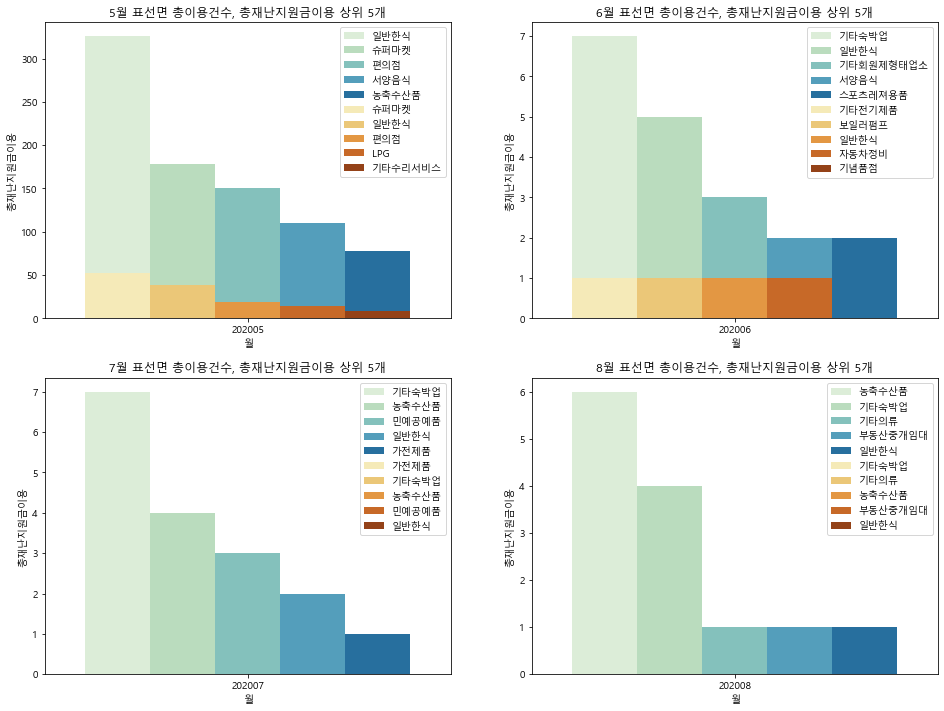

In [78]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.barplot(x='월', y='총이용건수', hue='업종', data=sg5['총이용건수'].groupby('월', group_keys=False).nlargest(5).reset_index(), palette='GnBu')
ax1 = sns.barplot(x='월', y='총재난지원금이용', hue='업종', data=sg5['총재난지원금이용'].groupby('월', group_keys=False).nlargest(5).reset_index(), palette='YlOrBr')
ax1.legend(loc='best', frameon=True)
ax1.set_title('5월 표선면 총이용건수, 총재난지원금이용 상위 5개')

ax1 = fig.add_subplot(2, 2, 2)
ax1 = sns.barplot(x='월', y='총이용건수', hue='업종', data=sg6['총이용건수'].groupby('월', group_keys=False).nlargest(5).reset_index(), palette='GnBu')
ax1 = sns.barplot(x='월', y='총재난지원금이용', hue='업종', data=sg6['총재난지원금이용'].groupby('월', group_keys=False).nlargest(5).reset_index(), palette='YlOrBr')
ax1.legend(loc='best', frameon=True)
ax1.set_title('6월 표선면 총이용건수, 총재난지원금이용 상위 5개')

ax3 = fig.add_subplot(2, 2, 3)
ax1 = sns.barplot(x='월', y='총이용건수', hue='업종', data=sg7['총이용건수'].groupby('월', group_keys=False).nlargest(5).reset_index(), palette='GnBu')
ax1 = sns.barplot(x='월', y='총재난지원금이용', hue='업종', data=sg7['총재난지원금이용'].groupby('월', group_keys=False).nlargest(5).reset_index(), palette='YlOrBr')
ax1.legend(loc='best', frameon=True)
ax1.set_title('7월 표선면 총이용건수, 총재난지원금이용 상위 5개')

ax4 = fig.add_subplot(2, 2, 4)
ax1 = sns.barplot(x='월', y='총이용건수', hue='업종', data=sg8['총이용건수'].groupby('월', group_keys=False).nlargest(5).reset_index(), palette='GnBu')
ax1 = sns.barplot(x='월', y='총재난지원금이용', hue='업종', data=sg8['총재난지원금이용'].groupby('월', group_keys=False).nlargest(5).reset_index(), palette='YlOrBr')
ax1.legend(loc='best', frameon=True)
ax1.set_title('8월 표선면 총이용건수, 총재난지원금이용 상위 5개')
plt.show()

#### 6,7월에 숙박업이 급증하는 것으로 확인 -> 관광객 유입이 증가, 축제 등의 행사가 있을 것으로 예측

## '표선면 축제' 관련 뉴스 가져오기

#### 표선면 축제에 대해서 뉴스에서 정보를 모으고 가장 언급이 많은 단어 찾기

#### 2020.05.01 ~ 2020.09.01 뉴스만 가져옴

In [91]:
import time
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
driver=webdriver.Chrome("c:/chromedriver.exe")

In [136]:
driver.get("https://www.naver.com/")
time.sleep(2) 

info=[]

for page in range(1,4):
    url = f"https://search.naver.com/search.naver?where=news&sm=tab_pge&query=%ED%91%9C%EC%84%A0%EB%A9%B4%20%EC%B6%95%EC%A0%9C&sort=0&photo=0&field=0&pd=3&ds=2020.05.01&de=2020.09.01&cluster_rank=17&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:r,p:from20200501to20200901,a:all&start={(page*10)-9}"
    driver.get(url)
    time.sleep(0.5)

    html=driver.page_source
    soup=BeautifulSoup(html, 'html.parser')
    news=soup.select("div.news_info")

    for i in range(len(news)):
        title=soup.select("div.news_wrap.api_ani_send > div > a")
        date=soup.select("div.news_info > div.info_group > span")
        
        tit=list(title)
        day=list(date)
        
        news_title=tit[i].text
        news_date=day[i].text
        
        info.append([news_title,news_date])

In [169]:
info

[['6월 관광객 맞이, 표선면 제주허브동산 입장 할인 실시', '2020.06.01.'],
 ['제주 허브동산, 수국 축제 기념 얼리버드 할인 이벤트 7월 31일까지 연장', '2020.07.07.'],
 ['제주 허브동산, 수국 축제 기념 얼리버드 할인 이벤트 7월 31일까지 연장', '2020.07.06.'],
 ['팬데믹 시대, 책으로 떠나는 힐링 제주 여행', '2020.08.20.'],
 ['제주해비치아트페스티벌, 온라인 페스티벌로 진행', '2020.08.20.'],
 ['올해 ‘제주해비치아트페스티벌’ 온라인 개최', '2020.08.16.'],
 ['[여름휴가 뭐하지?] \'코로나19\'로 사라진 여름 페스티벌, "온라인으로 즐기자...', '2020.07.31.'],
 ["'제주해비치아트페스티벌' 코로나19 여파로 온라인 개최", '2020.07.26.'],
 ["'제주해비치페스티벌' 코로나로 온라인 개최", '2020.07.24.'],
 ['‘제주해비치아트페스티벌’, 온라인 전환 개최', '2020.07.22.'],
 ['원시림에서 여유 한 걸음, 수국길 거닐며 힐링 두 걸음…"제주로 혼저옵서예"', 'B1면 1단'],
 ["[짤막 소식] '제5회 학교 재난안전 콘텐츠 공모전' 外", '2020.07.21.'],
 ['\'알록달록\' 색깔 변하는 \'수국\' "인생 샷 건질 명소 여기요!"', '2020.07.09.'],
 ["탐스러운 '수국' 따라 싱그러운 초여름여행!..수국명소 베스트 5", '2020.06.12.'],
 ['6월 제주도 수국 활짝, 수국 개화 맞이 제주허브동산 얼리버드 할인 이벤트 실...', '2020.06.02.'],
 ['국가무형문화재 공개행사 5월 말 전국 재개…예능 종목은 무관객 공연', '2020.06.03.'],
 ['문화재청, 국가무형문화재 공개행사 5월 말 재개', '2020.05.26.'],
 ['불금에는 ‘심야책방’으로… “전국 70개 책방 22시까지 불 밝혀요"', '2020.05.27.'],
 ['

In [151]:
infolist=[]
for i in range(len(info)):
    infolist.append(info[i][0])

In [182]:
infolist

['6월 관광객 맞이, 표선면 제주허브동산 입장 할인 실시',
 '제주 허브동산, 수국 축제 기념 얼리버드 할인 이벤트 7월 31일까지 연장',
 '제주 허브동산, 수국 축제 기념 얼리버드 할인 이벤트 7월 31일까지 연장',
 '팬데믹 시대, 책으로 떠나는 힐링 제주 여행',
 '제주해비치아트페스티벌, 온라인 페스티벌로 진행',
 '올해 ‘제주해비치아트페스티벌’ 온라인 개최',
 '[여름휴가 뭐하지?] \'코로나19\'로 사라진 여름 페스티벌, "온라인으로 즐기자...',
 "'제주해비치아트페스티벌' 코로나19 여파로 온라인 개최",
 "'제주해비치페스티벌' 코로나로 온라인 개최",
 '‘제주해비치아트페스티벌’, 온라인 전환 개최',
 '원시림에서 여유 한 걸음, 수국길 거닐며 힐링 두 걸음…"제주로 혼저옵서예"',
 "[짤막 소식] '제5회 학교 재난안전 콘텐츠 공모전' 外",
 '\'알록달록\' 색깔 변하는 \'수국\' "인생 샷 건질 명소 여기요!"',
 "탐스러운 '수국' 따라 싱그러운 초여름여행!..수국명소 베스트 5",
 '6월 제주도 수국 활짝, 수국 개화 맞이 제주허브동산 얼리버드 할인 이벤트 실...',
 '국가무형문화재 공개행사 5월 말 전국 재개…예능 종목은 무관객 공연',
 '문화재청, 국가무형문화재 공개행사 5월 말 재개',
 '불금에는 ‘심야책방’으로… “전국 70개 책방 22시까지 불 밝혀요"',
 '"화재 예방 이유로 대책 없이 농민 범법자 양산"',
 "보리·콩깎지 소각 과태료...현실 안 맞는 '탁상행정'",
 "6월 제주도 수국 활짝, '제주허브동산 얼리버드' 할인 이벤트 실시",
 '제주 표선 수국 활짝…“일단 사진 힐링…건강한 국민만 입도”',
 '"여름꽃 수국 활짝"…제주허브동산 할인 이벤트',
 '문화재청, 국가무형문화재 공개행사 5월 말 재개',
 '불금에는 ‘심야책방’으로… “전국 70개 책방 22시까지 불 밝혀요"',
 '문화재청 "국가무형문화재 공개행사 5월 말 재개"',
 '"화재 예방 이유로 대책 없이 농민

In [189]:
infolist_=[]
for j in range(len(info)):
    infolist_+=infolist[j].split(" ")

In [190]:
infolist_

['6월',
 '관광객',
 '맞이,',
 '표선면',
 '제주허브동산',
 '입장',
 '할인',
 '실시',
 '제주',
 '허브동산,',
 '수국',
 '축제',
 '기념',
 '얼리버드',
 '할인',
 '이벤트',
 '7월',
 '31일까지',
 '연장',
 '제주',
 '허브동산,',
 '수국',
 '축제',
 '기념',
 '얼리버드',
 '할인',
 '이벤트',
 '7월',
 '31일까지',
 '연장',
 '팬데믹',
 '시대,',
 '책으로',
 '떠나는',
 '힐링',
 '제주',
 '여행',
 '제주해비치아트페스티벌,',
 '온라인',
 '페스티벌로',
 '진행',
 '올해',
 '‘제주해비치아트페스티벌’',
 '온라인',
 '개최',
 '[여름휴가',
 '뭐하지?]',
 "'코로나19'로",
 '사라진',
 '여름',
 '페스티벌,',
 '"온라인으로',
 '즐기자...',
 "'제주해비치아트페스티벌'",
 '코로나19',
 '여파로',
 '온라인',
 '개최',
 "'제주해비치페스티벌'",
 '코로나로',
 '온라인',
 '개최',
 '‘제주해비치아트페스티벌’,',
 '온라인',
 '전환',
 '개최',
 '원시림에서',
 '여유',
 '한',
 '걸음,',
 '수국길',
 '거닐며',
 '힐링',
 '두',
 '걸음…"제주로',
 '혼저옵서예"',
 '[짤막',
 '소식]',
 "'제5회",
 '학교',
 '재난안전',
 '콘텐츠',
 "공모전'",
 '外',
 "'알록달록'",
 '색깔',
 '변하는',
 "'수국'",
 '"인생',
 '샷',
 '건질',
 '명소',
 '여기요!"',
 '탐스러운',
 "'수국'",
 '따라',
 '싱그러운',
 '초여름여행!..수국명소',
 '베스트',
 '5',
 '6월',
 '제주도',
 '수국',
 '활짝,',
 '수국',
 '개화',
 '맞이',
 '제주허브동산',
 '얼리버드',
 '할인',
 '이벤트',
 '실...',
 '국가무형문화재',
 '공개행사',
 '5월',
 '말',
 '전국

#### '표선면 축제' 뉴스에서 가장 언급이 많은 단어 찾기

In [191]:
# from collections import Counter

count_items = Counter(infolist_)
print(count_items)

Counter({'수국': 7, '할인': 6, '이벤트': 5, '온라인': 5, '제주': 4, '개최': 4, '공개행사': 4, '5월': 4, '말': 4, '6월': 3, '얼리버드': 3, '국가무형문화재': 3, '제주허브동산': 2, '실시': 2, '허브동산,': 2, '축제': 2, '기념': 2, '7월': 2, '31일까지': 2, '연장': 2, '힐링': 2, "'수국'": 2, '제주도': 2, '활짝,': 2, '문화재청,': 2, '재개': 2, '불금에는': 2, '‘심야책방’으로…': 2, '“전국': 2, '70개': 2, '책방': 2, '22시까지': 2, '불': 2, '밝혀요"': 2, '"화재': 2, '예방': 2, '이유로': 2, '대책': 2, '없이': 2, '농민': 2, '범법자': 2, '양산"': 2, '보리·콩깎지': 2, '소각': 2, '과태료...현실': 2, '안': 2, '맞는': 2, "'탁상행정'": 2, '관광객': 1, '맞이,': 1, '표선면': 1, '입장': 1, '팬데믹': 1, '시대,': 1, '책으로': 1, '떠나는': 1, '여행': 1, '제주해비치아트페스티벌,': 1, '페스티벌로': 1, '진행': 1, '올해': 1, '‘제주해비치아트페스티벌’': 1, '[여름휴가': 1, '뭐하지?]': 1, "'코로나19'로": 1, '사라진': 1, '여름': 1, '페스티벌,': 1, '"온라인으로': 1, '즐기자...': 1, "'제주해비치아트페스티벌'": 1, '코로나19': 1, '여파로': 1, "'제주해비치페스티벌'": 1, '코로나로': 1, '‘제주해비치아트페스티벌’,': 1, '전환': 1, '원시림에서': 1, '여유': 1, '한': 1, '걸음,': 1, '수국길': 1, '거닐며': 1, '두': 1, '걸음…"제주로': 1, '혼저옵서예"': 1, '[짤막': 1, '소식]': 1, "'제5회": 1, '학교': 1, '재난안전': 1, '

In [193]:
max_item = count_items.most_common(n=10) 
print(max_item)

[('수국', 7), ('할인', 6), ('이벤트', 5), ('온라인', 5), ('제주', 4), ('개최', 4), ('공개행사', 4), ('5월', 4), ('말', 4), ('6월', 3)]
